# Perform tethering analysis
- https://pubmed.ncbi.nlm.nih.gov/28945980/
- match PLP pipeline
- extend to multiple labeling
- visualize plate maps and %BPI curves
- depending on system, this analysis is ~10x faster than pipeline pilot

In [30]:
import os
import pandas as pd
import numpy as np

import sys
sys.path.append('/home/apaulson/repos/data-proc/')
import plate_maps as pm
%config Completer.use_jedi=False

# original analysis

In [33]:
%%time
# %debug

# # DATA INPUT # #

# # --------------------------------------- # #
HA_ID=2516
# # --------------------------------------- # #
# # --------------------------------------- # #
barcode=f'SMDC-MPHORE-384-4-02-Eco1'
# # --------------------------------------- # #
# # --------------------------------------- # #
pmirm=False # protein mass is reacted mass
cmirm=True # cap mass is reacted mass
rmirm=True # reductant mass is reacted mass
# # --------------------------------------- # #
# # --------------------------------------- # #
scan_range = 5
# # --------------------------------------- # #
# # --------------------------------------- # #
assay_class='HTS'
# # --------------------------------------- # #

infile=r"/Volumes/Shared/SMDC/Screens/2023-11_Project_XXX_Nsp14_Fujimori_Avidd4/2516/20231102/SMDC-MPHORE-384-4-02-Eco1.rpt"
file=infile.replace("\\","/").replace('Z:','/mnt/z').replace(" ","\\ ").replace("(","\\(").replace(")","\\)")
file=file.replace('{assay}',str(HA_ID))

cmd=f"grep -n '^Sample\s[0-9]' {file} > samples.txt"
os.system(cmd)

cmd=f"grep -n '^Well\s' {file} > wells.txt"
os.system(cmd)

cmd=f"grep -n '^FileName\s' {file} > fnames.txt"
os.system(cmd)

cmd=f"grep -n '^BPM\s' {file} > bpms.txt"
os.system(cmd)

cmd=f"grep -n '^BPI\s' {file} > bpis.txt"
os.system(cmd)

cmd=f"wc -l < {file} > linenum.txt"
os.system(cmd)

cmd=f"grep -n '^\;Mass' {file} > massstart.txt"
os.system(cmd)

search='}'
cmd=fr"grep -n {search} {file} > massend.txt"
os.system(cmd)

samples = pd.read_csv('samples.txt', sep=':', header=None)
wells = pd.read_csv('wells.txt', sep=':', header=None)
fnames = pd.read_csv('fnames.txt', sep=':', header=None)
bpms = pd.read_csv('bpms.txt', sep=':', header=None)
bpis = pd.read_csv('bpis.txt', sep=':', header=None)

samples.columns=['linenum','Sample']
wells.columns=['linenum','Plate','Well']
fnames.columns=['linenum','Fname']
bpms.columns=['linenum','BPM']
bpis.columns=['linenum','BPI']

# samples=samples[~samples.linenum.str.contains('Binary')]
# wells=wells[~wells.linenum.str.contains('Binary')]
# fnames=fnames[~fnames.linenum.str.contains('Binary')]
# bpms=bpms[~bpms.linenum.str.contains('Binary')]
# bpis=bpis[~bpis.linenum.str.contains('Binary')]

# samples.linenum=samples.linenum.astype(int)
# wells.linenum=wells.linenum.astype(int)
# fnames.linenum=fnames.linenum.astype(int)
# bpms.linenum=bpms.linenum.astype(int)
# bpis.linenum=bpis.linenum.astype(int)

samples.Sample=samples.Sample.str.replace('Sample\t','').astype(int)
wells.Plate=wells.Plate.str.replace('Well\t','').astype(int)
fnames.Fname=fnames.Fname.str.replace('FileName\t','')
bpms.BPM=bpms.BPM.str.replace('BPM\t','').astype(float)
bpis.BPI=bpis.BPI.str.replace('BPI\t','').astype(float)

wells['Sample']=np.nan
fnames['Sample']=np.nan
bpms['Sample']=np.nan
bpis['Sample']=np.nan

starts=pd.read_csv('massstart.txt', sep=':', header=None)
starts.columns=['linenum','headers']
# starts=starts[~starts.linenum.str.contains('Binary')]
# starts.linenum=starts.linenum.astype(int)
ends=pd.read_csv('massend.txt', sep=':', header=None)
ends.columns=['linenum','value']
# ends=ends[~ends.linenum.str.contains('Binary')]
# ends.linenum=ends.linenum.astype(int)

starts['Sample']=np.nan
ends['Sample']=np.nan

nl=pd.read_csv('linenum.txt', header=None)
linenum=nl.iloc[0][0]+1

nsamples=len(samples)

for i in range(nsamples):
# for i in [0,1,2]:
    if i==nsamples-1:
        linerange=range(samples.linenum.loc[i], linenum)
    else:
        linerange=range(samples.linenum.loc[i], samples.linenum.loc[i+1]+1)
    sample=samples.Sample.loc[i]
    wells.loc[wells.linenum.isin(linerange), 'Sample']=sample
    fnames.loc[fnames.linenum.isin(linerange), 'Sample']=sample
    bpis.loc[bpis.linenum.isin(linerange), 'Sample']=sample
    bpms.loc[bpms.linenum.isin(linerange), 'Sample']=sample
    starts.loc[starts.linenum.isin(linerange), 'Sample']=sample
    ends.loc[ends.linenum.isin(linerange), 'Sample']=sample

endrows=[]
for i in range(len(starts)):
    if i==len(starts)-1:
        linerange=range(starts.linenum.loc[i], linenum)
    else:
        linerange=range(starts.linenum.loc[i], starts.linenum.loc[i+1]+1)
    tmp=pd.DataFrame(ends[ends.linenum.isin(linerange)].iloc[0]).T
    endrows.append(tmp)
endrows=pd.concat(endrows)

file=infile.replace("\\","/").replace('Z:','/mnt/z')#.replace(" ","\\ ").replace("(","\\(").replace(")","\\)")
file=file.replace('{assay}', str(HA_ID))
with open(file, "rb") as f:
    content=f.readlines()

CPU times: user 753 ms, sys: 26.7 ms, total: 779 ms
Wall time: 937 ms


In [34]:
df=samples.merge(wells, how='left', on='Sample', suffixes=['_sample','_well'])
df=df.merge(fnames, how='left', on='Sample')
df=df.merge(bpis, how='left', on='Sample', suffixes=['_fname','_bpi'])
df=df.merge(bpms, how='left', on='Sample')
df=df.merge(starts, how='left', on='Sample', suffixes=['_bpm','_start'])
df=df.merge(endrows, how='left', on='Sample')
df=df[['Sample', 'Plate', 'Well', 'Fname', 'BPI', 'BPM', 'linenum_start', 'linenum']]
df.columns=['Sample', 'Plate', 'Well', 'Fname', 'intensitymax', 'massatmax', 'linenum_start', 'linenum']
df.linenum_start=df.linenum_start.replace(np.nan, -99).astype(int)
# df.linenum=df.linenum.replace(.astype(int)

for i, row in df.iterrows():
    if row.linenum_start==-99:
        continue
    samplefile=f'Sample_{str(row.Sample).zfill(3)}_data.txt'
    with open(samplefile, "wb") as f:
        f.writelines(content[row.linenum_start-1:row.linenum-1])

# %%time
# # DATA ANALYSIS # #

# lookup info in db for assay and plate

query1=f"""SELECT
(SELECT HAPA_VALUE
FROM HTS_ASSAY_PARAMETER
INNER JOIN HTS_ASSAY ON HA_ID = HAPA_HA_ID
WHERE HA_ID = {HA_ID} AND HAPA_HAPAT_ID = 57 AND HAPA_STATUS_ID = 1) AS 'site_count',
(SELECT HAPA_VALUE
FROM HTS_ASSAY_PARAMETER
INNER JOIN HTS_ASSAY ON HA_ID = HAPA_HA_ID
WHERE HA_ID = {HA_ID} AND HAPA_HAPAT_ID = 53 AND HAPA_STATUS_ID = 1) AS 'protein_mass',
(SELECT HAPA_VALUE
FROM HTS_ASSAY_PARAMETER
INNER JOIN HTS_ASSAY ON HA_ID = HAPA_HA_ID
WHERE HA_ID = {HA_ID}  AND HAPA_HAPAT_ID = 54 AND HAPA_STATUS_ID = 1) AS 'reductant_mass',
(SELECT HA_ID
FROM HTS_ASSAY
WHERE HA_ID = {HA_ID}) AS HA_ID"""
query2=f"""
SELECT IP_ID, IW_ID, ICL_IC_ID, ICL_ID, GROUP_CONCAT(ICAF_FEATURE SEPARATOR ";") AS adduct_mass
FROM INV_WELL
LEFT OUTER JOIN INV_COMP_LOT ON IW_ICL_ID = ICL_ID
LEFT OUTER JOIN INV_PLATE ON IP_ID = IW_IP_ID
LEFT OUTER JOIN INV_COMP_ANNOT ON ICL_IC_ID = ICA_IC_ID AND ICA_ICAT_ID =  8
LEFT OUTER JOIN INV_COMP_ANNOT_FEATURE ON ICAF_ICA_ID = ICA_ID
WHERE IP_BARCODE = '{barcode}'
GROUP BY IW_ID"""

query3=f"""
SELECT IP_ID, IW_ID, IW_COORDINATES as Well, ICL_IC_ID, ICL_ID, GROUP_CONCAT(ICAF_FEATURE SEPARATOR ";") AS cap_mass
FROM INV_WELL
LEFT OUTER JOIN INV_COMP_LOT ON IW_ICL_ID = ICL_ID
LEFT OUTER JOIN INV_PLATE ON IP_ID = IW_IP_ID
LEFT OUTER JOIN INV_COMP_ANNOT ON ICL_IC_ID = ICA_IC_ID AND ICA_ICAT_ID =  13
LEFT OUTER JOIN INV_COMP_ANNOT_FEATURE ON ICAF_ICA_ID = ICA_ID
WHERE IP_BARCODE = '{barcode}'
GROUP BY IW_ID"""

cnx = pm.create_mysql_cnx()
nums=pd.read_sql(query1, cnx)
adds=pd.read_sql(query2,cnx)
caps=pd.read_sql(query3,cnx)
cnx.dispose()

addcaps=adds.merge(caps)

hydrogen = 1.007825

protein_mass = nums.protein_mass.astype(float).iloc[0]
site_count = nums.site_count.astype(float).iloc[0]
reductant_mass = nums.reductant_mass.astype(float).iloc[0]

if pmirm:
    protein_mass=protein_mass+hydrogen # add hydrogen to get free protein mass
if not cmirm:
    caps.cap_mass=caps.cap_mass-hydrogen # remove hydrogen to get reacted mass
if not rmirm:
    reductant_mass=reductant_mass-hydrogen # remove hydrogen to get reacted mass

# free protein
free_protein_min=protein_mass-scan_range
free_protein_max=protein_mass+scan_range
# remove hydrogen again
protein_mass=protein_mass-hydrogen

# throw error if adduct_mass not defined
print(f"Adduct mass is not defined for {sum(addcaps.adduct_mass.isna())} rows.")
addcaps=addcaps[~addcaps.adduct_mass.isna()]
addcaps=addcaps[~addcaps.adduct_mass.astype(str).str.contains(';')]

# protein-adduct
addcaps['protein_1adduct_min']=protein_mass+addcaps.adduct_mass.astype(float)-scan_range
addcaps['protein_1adduct_max']=protein_mass+addcaps.adduct_mass.astype(float)+scan_range
#protein-reductant
addcaps['protein_1reductant_min']=protein_mass+reductant_mass-scan_range
addcaps['protein_1reductant_max']=protein_mass+reductant_mass+scan_range
#protein-cap
addcaps['protein_1cap_min']=protein_mass+addcaps.cap_mass.astype(float)-scan_range
addcaps['protein_1cap_max']=protein_mass+addcaps.cap_mass.astype(float)+scan_range

# two binding sites
if site_count >1:
    # TODO: add checks for adduct mass existence
    # protein + 2 adduct
    addcaps['protein_2adduct_min']=protein_mass + 2*addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_2adduct_max']=protein_mass + 2*addcaps.adduct_mass.astype(float) + scan_range
    # protein + adduct + cap
    addcaps['protein_1adduct_1cap_min'] = protein_mass + addcaps.adduct_mass.astype(float) + addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_1adduct_1cap_max'] = protein_mass + addcaps.adduct_mass.astype(float) + addcaps.cap_mass.astype(float) + scan_range
    # protein + adduct + reductant
    addcaps['protein_1reductant_1adduct_min'] = protein_mass + reductant_mass + addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_1reductant_1adduct_max'] = protein_mass + reductant_mass + addcaps.adduct_mass.astype(float) + scan_range
    # protein + 2 reductant
    addcaps['protein_2reductant_min'] = protein_mass + 2*reductant_mass - scan_range
    addcaps['protein_2reductant_max'] = protein_mass + 2*reductant_mass + scan_range
    # protein + reductant + cap
    addcaps['protein_1reductant_1cap_min'] = protein_mass + reductant_mass + addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_1reductant_1cap_max'] = protein_mass + reductant_mass + addcaps.cap_mass.astype(float) + scan_range
    # protein + 2 cap
    addcaps['protein_2cap_min'] = protein_mass + 2*addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_2cap_max'] = protein_mass + 2*addcaps.cap_mass.astype(float) + scan_range
    
    
    # protein + 3 adduct
    addcaps['protein_3adduct_min']=protein_mass + 3*addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_3adduct_max']=protein_mass + 3*addcaps.adduct_mass.astype(float) + scan_range
    
    # protein + adduct + cap
    addcaps['protein_2adduct_1cap_min'] = protein_mass + 2*addcaps.adduct_mass.astype(float) + addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_2adduct_1cap_max'] = protein_mass + 2*addcaps.adduct_mass.astype(float) + addcaps.cap_mass.astype(float) + scan_range
    
    addcaps['protein_1adduct_2cap_min'] = protein_mass + addcaps.adduct_mass.astype(float) + 2*addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_1adduct_2cap_max'] = protein_mass + addcaps.adduct_mass.astype(float) + 2*addcaps.cap_mass.astype(float) + scan_range
    
    # protein + adduct + reductant
    addcaps['protein_2reductant_1adduct_min'] = protein_mass + 2*reductant_mass + addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_2reductant_1adduct_max'] = protein_mass + 2*reductant_mass + addcaps.adduct_mass.astype(float) + scan_range
    
    addcaps['protein_1reductant_2adduct_min'] = protein_mass + reductant_mass + 2*addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_1reductant_2adduct_max'] = protein_mass + reductant_mass + 2*addcaps.adduct_mass.astype(float) + scan_range
    
    # protein + adduct + cap + reductant
    addcaps['protein_1adduct_1cap_1reductant_min'] = protein_mass + reductant_mass + addcaps.cap_mass.astype(float) + addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_1adduct_1cap_1reductant_max'] = protein_mass + reductant_mass + addcaps.cap_mass.astype(float) + addcaps.adduct_mass.astype(float) + scan_range
    
    # protein + 3 reductant
    addcaps['protein_3reductant_min'] = protein_mass + 3*reductant_mass - scan_range
    addcaps['protein_3reductant_max'] = protein_mass + 3*reductant_mass + scan_range
    
    # protein + reductant + cap
    addcaps['protein_2reductant_1cap_min'] = protein_mass + 2*reductant_mass + addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_2reductant_1cap_max'] = protein_mass + 2*reductant_mass + addcaps.cap_mass.astype(float) + scan_range
    
    addcaps['protein_1reductant_2cap_min'] = protein_mass + reductant_mass + 2*addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_1reductant_2cap_max'] = protein_mass + reductant_mass + 2*addcaps.cap_mass.astype(float) + scan_range
    
    # protein + 3 cap
    addcaps['protein_3cap_min'] = protein_mass + 3*addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_3cap_max'] = protein_mass + 3*addcaps.cap_mass.astype(float) + scan_range
    
df[['string']]=''
df[['protein','protein_adduct','protein_secondary','protein_2adduct','protein_3adduct','well_sum','well_cnt']]=0

df[['row','col']]=df.Well.str.split(',', expand=True)
df.Well=df.row+df.col.str.zfill(2)

addcaps['Plate']=df.Plate.iloc[0]
df=df.merge(addcaps, how='left')

rows=[]
for i, row in df.iterrows():
    if row.linenum_start==-99:
        continue
    # read raw data
    file=f'Sample_{str(row.Sample).zfill(3)}_data.txt'
    dat=pd.read_csv(file, sep='\t')
    dat.columns=['mass', 'intensity']
    # create string annot of dat
    dat['string']=pd.cut(dat.intensity, [-1., 10.5, 30., 50., 70., 100., 200.], labels=['','.','-','i','l','!'])
    row.string=''.join(dat.string)
    
    # add protein intensities, remove from dat
    # protein with no adduct
    tmp=dat[(dat.mass.between(row.protein_1cap_min, row.protein_1cap_max))|(dat.mass.between(free_protein_min, free_protein_max))|(dat.mass.between(row.protein_1reductant_min, row.protein_1reductant_max))]
    row.protein=tmp.intensity.sum()
    dat=dat[~dat.index.isin(tmp.index)]
    # add (Single) tethered intensities, remove from dat
    tmp=dat[dat.mass.between(row.protein_1adduct_min, row.protein_1adduct_max)]
    row.protein_adduct=tmp.intensity.sum()
    dat=dat[~dat.index.isin(tmp.index)]
    # add secondary labeling intensities, remove from dat
    if site_count>1:
        # 2caps, 2reds, 1cap1red (not labeled)
        tmp=dat[(dat.mass.between(row.protein_2cap_min, row.protein_2cap_max))|(dat.mass.between(row.protein_2reductant_min, row.protein_2reductant_max))|(dat.mass.between(row.protein_1reductant_1cap_min, row.protein_1reductant_1cap_max))]
        row.protein=row.protein+tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        # adduct-cap, adduct-red (single labeled at either spot)
        tmp=dat[(dat.mass.between(row.protein_1adduct_1cap_min,row.protein_1adduct_1cap_max))|(dat.mass.between(row.protein_1reductant_1adduct_min,row.protein_1reductant_1adduct_max))]
        row.protein_adduct=row.protein_adduct+tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        # adduct-adduct (double labeled at max 2 spots)
        tmp=dat[(dat.mass.between(row.protein_2adduct_min,row.protein_2adduct_min))]
        row.protein_2adduct=tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        
        # 3 caps, 3 reds, 2 cap 1 red, 2 red 1 cap (no label)
        tmp=dat[(dat.mass.between(row.protein_3cap_min,row.protein_3cap_max))|(dat.mass.between(row.protein_3reductant_min, row.protein_3reductant_max))|
                (dat.mass.between(row.protein_2reductant_1cap_min, row.protein_2reductant_1cap_max))|(dat.mass.between(row.protein_1reductant_2cap_min, row.protein_1reductant_2cap_max))]
        row.protein=row.protein+tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        # 1adduct-2cap, 1adduct-2red, 1adduct-1cap-1red (single)
        tmp=dat[(dat.mass.between(row.protein_1adduct_2cap_min, row.protein_1adduct_2cap_max))|(dat.mass.between(row.protein_2reductant_1adduct_min, row.protein_2reductant_1adduct_max))|
                (dat.mass.between(row.protein_1adduct_1cap_1reductant_min,row.protein_1adduct_1cap_1reductant_max))]
        row.protein_adduct=row.protein_adduct+tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        # 2adduct-1cap, 2adduct-1red (double)
        tmp=dat[(dat.mass.between(row.protein_2adduct_1cap_min, row.protein_2adduct_1cap_max))|(dat.mass.between(row.protein_1reductant_2adduct_min, row.protein_1reductant_2adduct_max))]
        row.protein_2adduct=tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        # 3 adduct (triple)
        tmp=dat[(dat.mass.between(row.protein_3adduct_min, row.protein_3adduct_max))]
        row.protein_3adduct=tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
                 
    # add max intensities if elsewhere, remove from dat (labeling at max intensity spot ignoring where it should be labeled)
    tmp=dat[dat.mass.between(row.massatmax-scan_range, row.massatmax+scan_range)]
    row.protein_secondary=tmp.intensity.sum()
    dat=dat[~dat.index.isin(tmp.index)]
    # add residual signal (background or other labeling)
    row.well_sum=dat.intensity.sum()
    row.well_cnt=len(dat)
    rows.append(pd.DataFrame(row).T)
df=pd.concat(rows)

# rename columns
df=df.rename(columns={
    'string':'intensityprint',
    'protein':'intensityprotein',            # sum of protein unlabeled peak (s) - unlabled single, unlabeled cap cap, unlabeled red red, unlabeled cap red
    'protein_adduct':'intensitytethered',    # sum of protein single labeled peak (s) - single label only, single + reductant, single + cap
    'protein_secondary':'intensitysecondary',# sum of protein at maximum intensity peak regardless of where it's expected
    'protein_2adduct':'intensitydoubletethered', # sum of protein at double labeled peaks
    'protein_3adduct':'intensitytripletethered', # sum of protein at triple labeled peaks
})

well_sum=df.well_sum.sum()                   # sum of all residual signal across all wells
well_cnt=df.well_cnt.sum()                   # sum of number of measured points contributing to residual signal across all wells

# calculate total (expected) intensity
df['intensitytotal']=df.intensityprotein+df.intensitytethered+df.intensitydoubletethered+df.intensitytripletethered

# calc percentages

# real labeling at expected masses (ignoring any secondary peak)
df['percentlabeled']=(df.intensitytethered+df.intensitydoubletethered+df.intensitytripletethered)/df.intensitytotal*100

# only filter if AssayClass is 'HighThroughputAssay' not dose response
if assay_class == 'HTS':
    df['note']=''
    df.loc[df.percentlabeled>=1,'note']='Percent labeled > 1'
    df.loc[df.percentlabeled<0.001,'note']='Percent labeled < 0.001'

# secondary mass that doesn't represent expected mass peaks
df['percentsecondary']=df.intensitysecondary/(df.intensitytotal+df.intensitysecondary)*100

# single labeling at expected mass
df['percentsinglelabeled']=df.intensitytethered/(df.intensitytotal)*100

# percent double labeled at expected masses
if site_count>1:
    df['percentdoublelabeled']=df.intensitydoubletethered/(df.intensitytotal)*100
    df['percenttriplelabeled']=df.intensitytripletethered/(df.intensitytotal)*100

# ignore secondary peak if it's smaller than bound protein peak
df.loc[df.percentsecondary<df.percentlabeled, 'percentsecondary']=0
df.loc[df.percentsecondary<df.percentlabeled, 'spectrashift']=0
# otherwise note spectra shift (delta in mass of max intensity peak vs protein alone peak
df.loc[df.percentsecondary>=df.percentlabeled, 'spectrashift']=df.loc[df.percentsecondary>=df.percentlabeled, 'massatmax']-protein_mass

# what percentage of peaks were binned meaningfully?
# ratio of expected mass intensity to well total sum
# intensity of all peaks noted / all peaks noted plus extra signal
df['signalsignificance']=100*(df.intensitytotal+df.intensitysecondary)/(df.well_sum+df.intensitytotal+df.intensitysecondary)
# TODO: remove properties before insertion into db? "protein", "protein_adduct", "protein_secondary", "protein_2adduct", "well_sum", "mass", "intensity"

Adduct mass is not defined for 64 rows.


/tmp/ipykernel_6564/186122913.py:278: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2.0078250000005937 2.0078250000005937 2.0078250000005937
 1.0078250000005937 4.007825000000594 1.0078250000005937
 3.0078250000005937 2.0078250000005937 65.0078250000006 63.007825000000594
 2.0078250000005937 2.0078250000005937 2.0078250000005937 65.0078250000006
 2.0078250000005937 64.0078250000006 2.0078250000005937
 0.007825000000593718 0.007825000000593718 2.0078250000005937
 2.0078250000005937 -0.9921749999994063 2.0078250000005937
 2.0078250000005937 5.007825000000594 0.007825000000593718
 1.0078250000005937 2.0078250000005937 66.0078250000006 3.0078250000005937
 -0.9921749999994063 2.0078250000005937 66.0078250000006 66.0078250000006
 66.0078250000006 66.0078250000006 65.0078250000006 66.0078250000006
 2.0078250000005937 2.0078250000005937 2.0078250000005937
 2.0078250000005937 1.0078250000005937 0.007825000000593718
 2.0078

# Base protein with and without its own adduct

## Read RPT file

In [119]:
%%time
# %debug

# # DATA INPUT # #

# # --------------------------------------- # #
HA_ID=2516
# # --------------------------------------- # #
# # --------------------------------------- # #
barcode=f'SMDC-MPHORE-384-3-02-ECO1'
# # --------------------------------------- # #
# # --------------------------------------- # #
pmirm=False # protein mass is reacted mass
cmirm=True # cap mass is reacted mass
rmirm=True # reductant mass is reacted mass
# # --------------------------------------- # #
# # --------------------------------------- # #
scan_range = 5
# # --------------------------------------- # #
# # --------------------------------------- # #
assay_class='HTS'
# # --------------------------------------- # #

infile=r"/Volumes/Shared/SMDC/Screens/2023-11_Project_XXX_Nsp14_Fujimori_Avidd4/2516/20231102/{barcode}.rpt"
file=infile.replace("\\","/").replace('Z:','/mnt/z').replace(" ","\\ ").replace("(","\\(").replace(")","\\)")
file=file.replace('{assay}',str(HA_ID)).replace('{barcode}', barcode)

cmd=f"grep -n '^Sample\s[0-9]' {file} > samples.txt"
os.system(cmd)

cmd=f"grep -n '^Well\s' {file} > wells.txt"
os.system(cmd)

cmd=f"grep -n '^FileName\s' {file} > fnames.txt"
os.system(cmd)

cmd=f"grep -n '^BPM\s' {file} > bpms.txt"
os.system(cmd)

cmd=f"grep -n '^BPI\s' {file} > bpis.txt"
os.system(cmd)

cmd=f"wc -l < {file} > linenum.txt"
os.system(cmd)

cmd=f"grep -n '^\;Mass' {file} > massstart.txt"
os.system(cmd)

search='}'
cmd=fr"grep -n {search} {file} > massend.txt"
os.system(cmd)

samples = pd.read_csv('samples.txt', sep=':', header=None)
wells = pd.read_csv('wells.txt', sep=':', header=None)
fnames = pd.read_csv('fnames.txt', sep=':', header=None)
bpms = pd.read_csv('bpms.txt', sep=':', header=None)
bpis = pd.read_csv('bpis.txt', sep=':', header=None)

samples.columns=['linenum','Sample']
wells.columns=['linenum','Plate','Well']
fnames.columns=['linenum','Fname']
bpms.columns=['linenum','BPM']
bpis.columns=['linenum','BPI']

# samples=samples[~samples.linenum.str.contains('Binary')]
# wells=wells[~wells.linenum.str.contains('Binary')]
# fnames=fnames[~fnames.linenum.str.contains('Binary')]
# bpms=bpms[~bpms.linenum.str.contains('Binary')]
# bpis=bpis[~bpis.linenum.str.contains('Binary')]

# samples.linenum=samples.linenum.astype(int)
# wells.linenum=wells.linenum.astype(int)
# fnames.linenum=fnames.linenum.astype(int)
# bpms.linenum=bpms.linenum.astype(int)
# bpis.linenum=bpis.linenum.astype(int)

samples.Sample=samples.Sample.str.replace('Sample\t','').astype(int)
wells.Plate=wells.Plate.str.replace('Well\t','').astype(int)
fnames.Fname=fnames.Fname.str.replace('FileName\t','')
bpms.BPM=bpms.BPM.str.replace('BPM\t','').astype(float)
bpis.BPI=bpis.BPI.str.replace('BPI\t','').astype(float)

wells['Sample']=np.nan
fnames['Sample']=np.nan
bpms['Sample']=np.nan
bpis['Sample']=np.nan

starts=pd.read_csv('massstart.txt', sep=':', header=None)
starts.columns=['linenum','headers']
# starts=starts[~starts.linenum.str.contains('Binary')]
# starts.linenum=starts.linenum.astype(int)
ends=pd.read_csv('massend.txt', sep=':', header=None)
ends.columns=['linenum','value']
# ends=ends[~ends.linenum.str.contains('Binary')]
# ends.linenum=ends.linenum.astype(int)

starts['Sample']=np.nan
ends['Sample']=np.nan

nl=pd.read_csv('linenum.txt', header=None)
linenum=nl.iloc[0][0]+1

nsamples=len(samples)

for i in range(nsamples):
# for i in [0,1,2]:
    if i==nsamples-1:
        linerange=range(samples.linenum.loc[i], linenum)
    else:
        linerange=range(samples.linenum.loc[i], samples.linenum.loc[i+1]+1)
    sample=samples.Sample.loc[i]
    wells.loc[wells.linenum.isin(linerange), 'Sample']=sample
    fnames.loc[fnames.linenum.isin(linerange), 'Sample']=sample
    bpis.loc[bpis.linenum.isin(linerange), 'Sample']=sample
    bpms.loc[bpms.linenum.isin(linerange), 'Sample']=sample
    starts.loc[starts.linenum.isin(linerange), 'Sample']=sample
    ends.loc[ends.linenum.isin(linerange), 'Sample']=sample

endrows=[]
for i in range(len(starts)):
    if i==len(starts)-1:
        linerange=range(starts.linenum.loc[i], linenum)
    else:
        linerange=range(starts.linenum.loc[i], starts.linenum.loc[i+1]+1)
    tmp=pd.DataFrame(ends[ends.linenum.isin(linerange)].iloc[0]).T
    endrows.append(tmp)
endrows=pd.concat(endrows)

with open(file, "rb") as f:
    content=f.readlines()

CPU times: user 815 ms, sys: 17 ms, total: 832 ms
Wall time: 1.04 s


## Process data

In [120]:
df=samples.merge(wells, how='left', on='Sample', suffixes=['_sample','_well'])
df=df.merge(fnames, how='left', on='Sample')
df=df.merge(bpis, how='left', on='Sample', suffixes=['_fname','_bpi'])
df=df.merge(bpms, how='left', on='Sample')
df=df.merge(starts, how='left', on='Sample', suffixes=['_bpm','_start'])
df=df.merge(endrows, how='left', on='Sample')
df=df[['Sample', 'Plate', 'Well', 'Fname', 'BPI', 'BPM', 'linenum_start', 'linenum']]
df.columns=['Sample', 'Plate', 'Well', 'Fname', 'intensitymax', 'massatmax', 'linenum_start', 'linenum']
df.linenum_start=df.linenum_start.replace(np.nan, -99).astype(int)
# df.linenum=df.linenum.replace(.astype(int)

for i, row in df.iterrows():
    if row.linenum_start==-99:
        continue
    samplefile=f'Sample_{str(row.Sample).zfill(3)}_data.txt'
    with open(samplefile, "wb") as f:
        f.writelines(content[row.linenum_start-1:row.linenum-1])

# %%time
# # DATA ANALYSIS # #

# lookup info in db for assay and plate

query1=f"""SELECT
(SELECT HAPA_VALUE
FROM HTS_ASSAY_PARAMETER
INNER JOIN HTS_ASSAY ON HA_ID = HAPA_HA_ID
WHERE HA_ID = {HA_ID} AND HAPA_HAPAT_ID = 57 AND HAPA_STATUS_ID = 1) AS 'site_count',
(SELECT HAPA_VALUE
FROM HTS_ASSAY_PARAMETER
INNER JOIN HTS_ASSAY ON HA_ID = HAPA_HA_ID
WHERE HA_ID = {HA_ID} AND HAPA_HAPAT_ID = 53 AND HAPA_STATUS_ID = 1) AS 'protein_mass',
(SELECT HAPA_VALUE
FROM HTS_ASSAY_PARAMETER
INNER JOIN HTS_ASSAY ON HA_ID = HAPA_HA_ID
WHERE HA_ID = {HA_ID}  AND HAPA_HAPAT_ID = 54 AND HAPA_STATUS_ID = 1) AS 'reductant_mass',
(SELECT HA_ID
FROM HTS_ASSAY
WHERE HA_ID = {HA_ID}) AS HA_ID"""
query2=f"""
SELECT IP_ID, IW_ID, ICL_IC_ID, ICL_ID, ICAF_FEATURE AS adduct_mass
FROM INV_WELL
LEFT OUTER JOIN INV_COMP_LOT ON IW_ICL_ID = ICL_ID
LEFT OUTER JOIN INV_PLATE ON IP_ID = IW_IP_ID
LEFT OUTER JOIN INV_COMP_ANNOT ON ICL_IC_ID = ICA_IC_ID AND ICA_ICAT_ID =  8
LEFT OUTER JOIN INV_COMP_ANNOT_FEATURE ON ICAF_ICA_ID = ICA_ID
WHERE IP_BARCODE = '{barcode}'
"""
query3=f"""
SELECT IP_ID, IW_ID, IW_COORDINATES as Well, ICL_IC_ID, ICL_ID, ICAF_FEATURE AS cap_mass
FROM INV_WELL
LEFT OUTER JOIN INV_COMP_LOT ON IW_ICL_ID = ICL_ID
LEFT OUTER JOIN INV_PLATE ON IP_ID = IW_IP_ID
LEFT OUTER JOIN INV_COMP_ANNOT ON ICL_IC_ID = ICA_IC_ID AND ICA_ICAT_ID =  13
LEFT OUTER JOIN INV_COMP_ANNOT_FEATURE ON ICAF_ICA_ID = ICA_ID
WHERE IP_BARCODE = '{barcode}'
"""
HA_ID2=2517
query12=f"""SELECT
(SELECT HAPA_VALUE
FROM HTS_ASSAY_PARAMETER
INNER JOIN HTS_ASSAY ON HA_ID = HAPA_HA_ID
WHERE HA_ID = {HA_ID2} AND HAPA_HAPAT_ID = 57 AND HAPA_STATUS_ID = 1) AS 'site_count',
(SELECT HAPA_VALUE
FROM HTS_ASSAY_PARAMETER
INNER JOIN HTS_ASSAY ON HA_ID = HAPA_HA_ID
WHERE HA_ID = {HA_ID2} AND HAPA_HAPAT_ID = 53 AND HAPA_STATUS_ID = 1) AS 'protein_mass',
(SELECT HAPA_VALUE
FROM HTS_ASSAY_PARAMETER
INNER JOIN HTS_ASSAY ON HA_ID = HAPA_HA_ID
WHERE HA_ID = {HA_ID2}  AND HAPA_HAPAT_ID = 54 AND HAPA_STATUS_ID = 1) AS 'reductant_mass',
(SELECT HA_ID
FROM HTS_ASSAY
WHERE HA_ID = {HA_ID2}) AS HA_ID"""

cnx = pm.create_mysql_cnx()
nums=pd.read_sql(query1, cnx)
nums2=pd.read_sql(query12, cnx)
adds=pd.read_sql(query2,cnx)
caps=pd.read_sql(query3,cnx)
cnx.dispose()

addcaps=adds.merge(caps)

hydrogen = 1.007825

protein_mass = nums.protein_mass.astype(float).iloc[0]
protein_mass2 = nums2.protein_mass.astype(float).iloc[0]
site_count = nums.site_count.astype(float).iloc[0]
reductant_mass = nums.reductant_mass.astype(float).iloc[0]

addcaps.shape

(532, 7)

In [121]:
if pmirm:
    protein_mass=protein_mass+hydrogen # add hydrogen to get free protein mass
    protein_mass2=protein_mass2+hydrogen
if not cmirm:
    caps.cap_mass=caps.cap_mass-hydrogen # remove hydrogen to get reacted mass
if not rmirm:
    reductant_mass=reductant_mass-hydrogen # remove hydrogen to get reacted mass

# free protein
free_protein_min=protein_mass-scan_range
free_protein_max=protein_mass+scan_range

free_protein2_min=protein_mass2-scan_range
free_protein2_max=protein_mass2+scan_range

# remove hydrogen again
protein_mass=protein_mass-hydrogen
protein_mass2=protein_mass2-hydrogen

# throw error if adduct_mass not defined
print(f"Adduct mass is not defined for {len(addcaps[(addcaps.adduct_mass.isna())&(~addcaps.ICL_IC_ID.isna())])} compounds.")
addcaps=addcaps[~addcaps.adduct_mass.isna()]
addcaps=addcaps[~addcaps.adduct_mass.astype(str).str.contains(';')]

# protein-adduct
addcaps['protein_1adduct_min']=protein_mass+addcaps.adduct_mass.astype(float)-scan_range
addcaps['protein_1adduct_max']=protein_mass+addcaps.adduct_mass.astype(float)+scan_range
#protein-reductant
addcaps['protein_1reductant_min']=protein_mass+reductant_mass-scan_range
addcaps['protein_1reductant_max']=protein_mass+reductant_mass+scan_range
#protein-cap
addcaps['protein_1cap_min']=protein_mass+addcaps.cap_mass.astype(float)-scan_range
addcaps['protein_1cap_max']=protein_mass+addcaps.cap_mass.astype(float)+scan_range

# protein-adduct 2
addcaps['protein2_1adduct_min']=protein_mass2+addcaps.adduct_mass.astype(float)-scan_range
addcaps['protein2_1adduct_max']=protein_mass2+addcaps.adduct_mass.astype(float)+scan_range
#protein-reductant 2
addcaps['protein2_1reductant_min']=protein_mass2+reductant_mass-scan_range
addcaps['protein2_1reductant_max']=protein_mass2+reductant_mass+scan_range
#protein-cap 2
addcaps['protein2_1cap_min']=protein_mass2+addcaps.cap_mass.astype(float)-scan_range
addcaps['protein2_1cap_max']=protein_mass2+addcaps.cap_mass.astype(float)+scan_range


# two binding sites
if site_count >1:
    # TODO: add checks for adduct mass existence
    # protein + 2 adduct
    addcaps['protein_2adduct_min']=protein_mass + 2*addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_2adduct_max']=protein_mass + 2*addcaps.adduct_mass.astype(float) + scan_range
    # protein + adduct + cap
    addcaps['protein_1adduct_1cap_min'] = protein_mass + addcaps.adduct_mass.astype(float) + addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_1adduct_1cap_max'] = protein_mass + addcaps.adduct_mass.astype(float) + addcaps.cap_mass.astype(float) + scan_range
    # protein + adduct + reductant
    addcaps['protein_1reductant_1adduct_min'] = protein_mass + reductant_mass + addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_1reductant_1adduct_max'] = protein_mass + reductant_mass + addcaps.adduct_mass.astype(float) + scan_range
    # protein + 2 reductant
    addcaps['protein_2reductant_min'] = protein_mass + 2*reductant_mass - scan_range
    addcaps['protein_2reductant_max'] = protein_mass + 2*reductant_mass + scan_range
    # protein + reductant + cap
    addcaps['protein_1reductant_1cap_min'] = protein_mass + reductant_mass + addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_1reductant_1cap_max'] = protein_mass + reductant_mass + addcaps.cap_mass.astype(float) + scan_range
    # protein + 2 cap
    addcaps['protein_2cap_min'] = protein_mass + 2*addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_2cap_max'] = protein_mass + 2*addcaps.cap_mass.astype(float) + scan_range
    
    
    # protein + 3 adduct
    addcaps['protein_3adduct_min']=protein_mass + 3*addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_3adduct_max']=protein_mass + 3*addcaps.adduct_mass.astype(float) + scan_range
    
    # protein + adduct + cap
    addcaps['protein_2adduct_1cap_min'] = protein_mass + 2*addcaps.adduct_mass.astype(float) + addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_2adduct_1cap_max'] = protein_mass + 2*addcaps.adduct_mass.astype(float) + addcaps.cap_mass.astype(float) + scan_range
    
    addcaps['protein_1adduct_2cap_min'] = protein_mass + addcaps.adduct_mass.astype(float) + 2*addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_1adduct_2cap_max'] = protein_mass + addcaps.adduct_mass.astype(float) + 2*addcaps.cap_mass.astype(float) + scan_range
    
    # protein + adduct + reductant
    addcaps['protein_2reductant_1adduct_min'] = protein_mass + 2*reductant_mass + addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_2reductant_1adduct_max'] = protein_mass + 2*reductant_mass + addcaps.adduct_mass.astype(float) + scan_range
    
    addcaps['protein_1reductant_2adduct_min'] = protein_mass + reductant_mass + 2*addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_1reductant_2adduct_max'] = protein_mass + reductant_mass + 2*addcaps.adduct_mass.astype(float) + scan_range
    
    # protein + adduct + cap + reductant
    addcaps['protein_1adduct_1cap_1reductant_min'] = protein_mass + reductant_mass + addcaps.cap_mass.astype(float) + addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_1adduct_1cap_1reductant_max'] = protein_mass + reductant_mass + addcaps.cap_mass.astype(float) + addcaps.adduct_mass.astype(float) + scan_range
    
    # protein + 3 reductant
    addcaps['protein_3reductant_min'] = protein_mass + 3*reductant_mass - scan_range
    addcaps['protein_3reductant_max'] = protein_mass + 3*reductant_mass + scan_range
    
    # protein + reductant + cap
    addcaps['protein_2reductant_1cap_min'] = protein_mass + 2*reductant_mass + addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_2reductant_1cap_max'] = protein_mass + 2*reductant_mass + addcaps.cap_mass.astype(float) + scan_range
    
    addcaps['protein_1reductant_2cap_min'] = protein_mass + reductant_mass + 2*addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_1reductant_2cap_max'] = protein_mass + reductant_mass + 2*addcaps.cap_mass.astype(float) + scan_range
    
    # protein + 3 cap
    addcaps['protein_3cap_min'] = protein_mass + 3*addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_3cap_max'] = protein_mass + 3*addcaps.cap_mass.astype(float) + scan_range
    
df[['string']]=''
df[['protein','protein_adduct','protein_secondary','protein_2adduct','protein_3adduct','well_sum','well_cnt']]=0

df[['row','col']]=df.Well.str.split(',', expand=True)
df.Well=df.row+df.col.str.zfill(2)

addcaps['Plate']=df.Plate.iloc[0]
df=df.merge(addcaps, how='left')

rows=[]
for i, row in df.iterrows():
    if row.linenum_start==-99:
        continue
    # read raw data
    file=f'Sample_{str(row.Sample).zfill(3)}_data.txt'
    dat=pd.read_csv(file, sep='\t')
    dat.columns=['mass', 'intensity']
    # create string annot of dat
    dat['string']=pd.cut(dat.intensity, [-1., 10.5, 30., 50., 70., 100., 200.], labels=['','.','-','i','l','!'])
    row.string=''.join(dat.string)
    
    # add protein intensities, remove from dat
    dat2=dat.copy(deep=True)
    # protein with no adduct
    tmp=dat[(dat.mass.between(row.protein_1cap_min, row.protein_1cap_max))|(dat.mass.between(free_protein_min, free_protein_max))|(dat.mass.between(row.protein_1reductant_min, row.protein_1reductant_max))]
    tmp2=dat2[(dat2.mass.between(row.protein2_1cap_min, row.protein2_1cap_max))|(dat2.mass.between(free_protein2_min, free_protein2_max))|(dat2.mass.between(row.protein2_1reductant_min, row.protein2_1reductant_max))]
    row.protein=tmp.intensity.sum()+tmp2.intensity.sum()
    dat=dat[~dat.index.isin(tmp.index)]
    dat2=dat2[~dat2.index.isin(tmp2.index)]
    
    # add (Single) tethered intensities, remove from dat
    tmp=dat[dat.mass.between(row.protein_1adduct_min, row.protein_1adduct_max)]
    tmp2=dat2[dat2.mass.between(row.protein2_1adduct_min, row.protein2_1adduct_max)]
    row.protein_adduct=tmp.intensity.sum()+tmp2.intensity.sum()
    dat=dat[~dat.index.isin(tmp.index)]
    dat2=dat2[~dat2.index.isin(tmp2.index)]
    
    # add secondary labeling intensities, remove from dat
    if site_count>1:
        # 2caps, 2reds, 1cap1red (not labeled)
        tmp=dat[(dat.mass.between(row.protein_2cap_min, row.protein_2cap_max))|(dat.mass.between(row.protein_2reductant_min, row.protein_2reductant_max))|(dat.mass.between(row.protein_1reductant_1cap_min, row.protein_1reductant_1cap_max))]
        row.protein=row.protein+tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        # adduct-cap, adduct-red (single labeled at either spot)
        tmp=dat[(dat.mass.between(row.protein_1adduct_1cap_min,row.protein_1adduct_1cap_max))|(dat.mass.between(row.protein_1reductant_1adduct_min,row.protein_1reductant_1adduct_max))]
        row.protein_adduct=row.protein_adduct+tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        # adduct-adduct (double labeled at max 2 spots)
        tmp=dat[(dat.mass.between(row.protein_2adduct_min,row.protein_2adduct_min))]
        row.protein_2adduct=tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        
        # 3 caps, 3 reds, 2 cap 1 red, 2 red 1 cap (no label)
        tmp=dat[(dat.mass.between(row.protein_3cap_min,row.protein_3cap_max))|(dat.mass.between(row.protein_3reductant_min, row.protein_3reductant_max))|
                (dat.mass.between(row.protein_2reductant_1cap_min, row.protein_2reductant_1cap_max))|(dat.mass.between(row.protein_1reductant_2cap_min, row.protein_1reductant_2cap_max))]
        row.protein=row.protein+tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        # 1adduct-2cap, 1adduct-2red, 1adduct-1cap-1red (single)
        tmp=dat[(dat.mass.between(row.protein_1adduct_2cap_min, row.protein_1adduct_2cap_max))|(dat.mass.between(row.protein_2reductant_1adduct_min, row.protein_2reductant_1adduct_max))|
                (dat.mass.between(row.protein_1adduct_1cap_1reductant_min,row.protein_1adduct_1cap_1reductant_max))]
        row.protein_adduct=row.protein_adduct+tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        # 2adduct-1cap, 2adduct-1red (double)
        tmp=dat[(dat.mass.between(row.protein_2adduct_1cap_min, row.protein_2adduct_1cap_max))|(dat.mass.between(row.protein_1reductant_2adduct_min, row.protein_1reductant_2adduct_max))]
        row.protein_2adduct=tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        # 3 adduct (triple)
        tmp=dat[(dat.mass.between(row.protein_3adduct_min, row.protein_3adduct_max))]
        row.protein_3adduct=tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
                 
    # add max intensities if elsewhere, remove from dat (labeling at max intensity spot ignoring where it should be labeled)
    tmp=dat[dat.mass.between(row.massatmax-scan_range, row.massatmax+scan_range)]
    tmp2=dat2[dat2.mass.between(row.massatmax-scan_range, row.massatmax+scan_range)]
    row.protein_secondary=tmp.intensity.sum()+tmp2.intensity.sum()
    dat=dat[~dat.index.isin(tmp.index)]
    dat2=dat2[~dat2.index.isin(tmp2.index)]
    
    # add residual signal (background or other labeling)
    dat2=dat2[dat2.index.isin(dat.index)] # only overlapping indices are actual background
    row.well_sum=dat2.intensity.sum()
    row.well_cnt=len(dat2)
    rows.append(pd.DataFrame(row).T)
df=pd.concat(rows)

# rename columns
df=df.rename(columns={
    'string':'intensityprint',
    'protein':'intensityprotein',            # sum of protein unlabeled peak (s) - unlabled single, unlabeled cap cap, unlabeled red red, unlabeled cap red
    'protein_adduct':'intensitytethered',    # sum of protein single labeled peak (s) - single label only, single + reductant, single + cap
    'protein_secondary':'intensitysecondary',# sum of protein at maximum intensity peak regardless of where it's expected
    'protein_2adduct':'intensitydoubletethered', # sum of protein at double labeled peaks
    'protein_3adduct':'intensitytripletethered', # sum of protein at triple labeled peaks
})

well_sum=df.well_sum.sum()                   # sum of all residual signal across all wells
well_cnt=df.well_cnt.sum()                   # sum of number of measured points contributing to residual signal across all wells

# calculate total (expected) intensity
df['intensitytotal']=df.intensityprotein+df.intensitytethered+df.intensitydoubletethered+df.intensitytripletethered

# calc percentages

# real labeling at expected masses (ignoring any secondary peak)
df['percentlabeled']=(df.intensitytethered+df.intensitydoubletethered+df.intensitytripletethered)/df.intensitytotal*100

# only filter if AssayClass is 'HighThroughputAssay' not dose response
if assay_class == 'HTS':
    df['note']=''
    df.loc[df.percentlabeled>=1,'note']='Percent labeled > 1'
    df.loc[df.percentlabeled<0.001,'note']='Percent labeled < 0.001'

# secondary mass that doesn't represent expected mass peaks
df['percentsecondary']=df.intensitysecondary/(df.intensitytotal+df.intensitysecondary)*100

# single labeling at expected mass
df['percentsinglelabeled']=df.intensitytethered/(df.intensitytotal)*100

# percent double labeled at expected masses
if site_count>1:
    df['percentdoublelabeled']=df.intensitydoubletethered/(df.intensitytotal)*100
    df['percenttriplelabeled']=df.intensitytripletethered/(df.intensitytotal)*100

# ignore secondary peak if it's smaller than bound protein peak
df.loc[df.percentsecondary<df.percentlabeled, 'percentsecondary']=0
df.loc[df.percentsecondary<df.percentlabeled, 'spectrashift']=0
# otherwise note spectra shift (delta in mass of max intensity peak vs protein alone peak
df.massatmax=df.massatmax.astype(float)
df.loc[df.percentsecondary>=df.percentlabeled, 'spectrashift']=df.loc[df.percentsecondary>=df.percentlabeled, 'massatmax']-protein_mass

# what percentage of peaks were binned meaningfully?
# ratio of expected mass intensity to well total sum
# intensity of all peaks noted / all peaks noted plus extra signal
df['signalsignificance']=100*(df.intensitytotal+df.intensitysecondary)/(df.well_sum+df.intensitytotal+df.intensitysecondary)
# TODO: remove properties before insertion into db? "protein", "protein_adduct", "protein_secondary", "protein_2adduct", "well_sum", "mass", "intensity"

Adduct mass is not defined for 0 compounds.


# Visualize plates and traces

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
df.Plate.unique()

array([1], dtype=object)

In [123]:
barcode

'SMDC-MPHORE-384-3-02-ECO1'

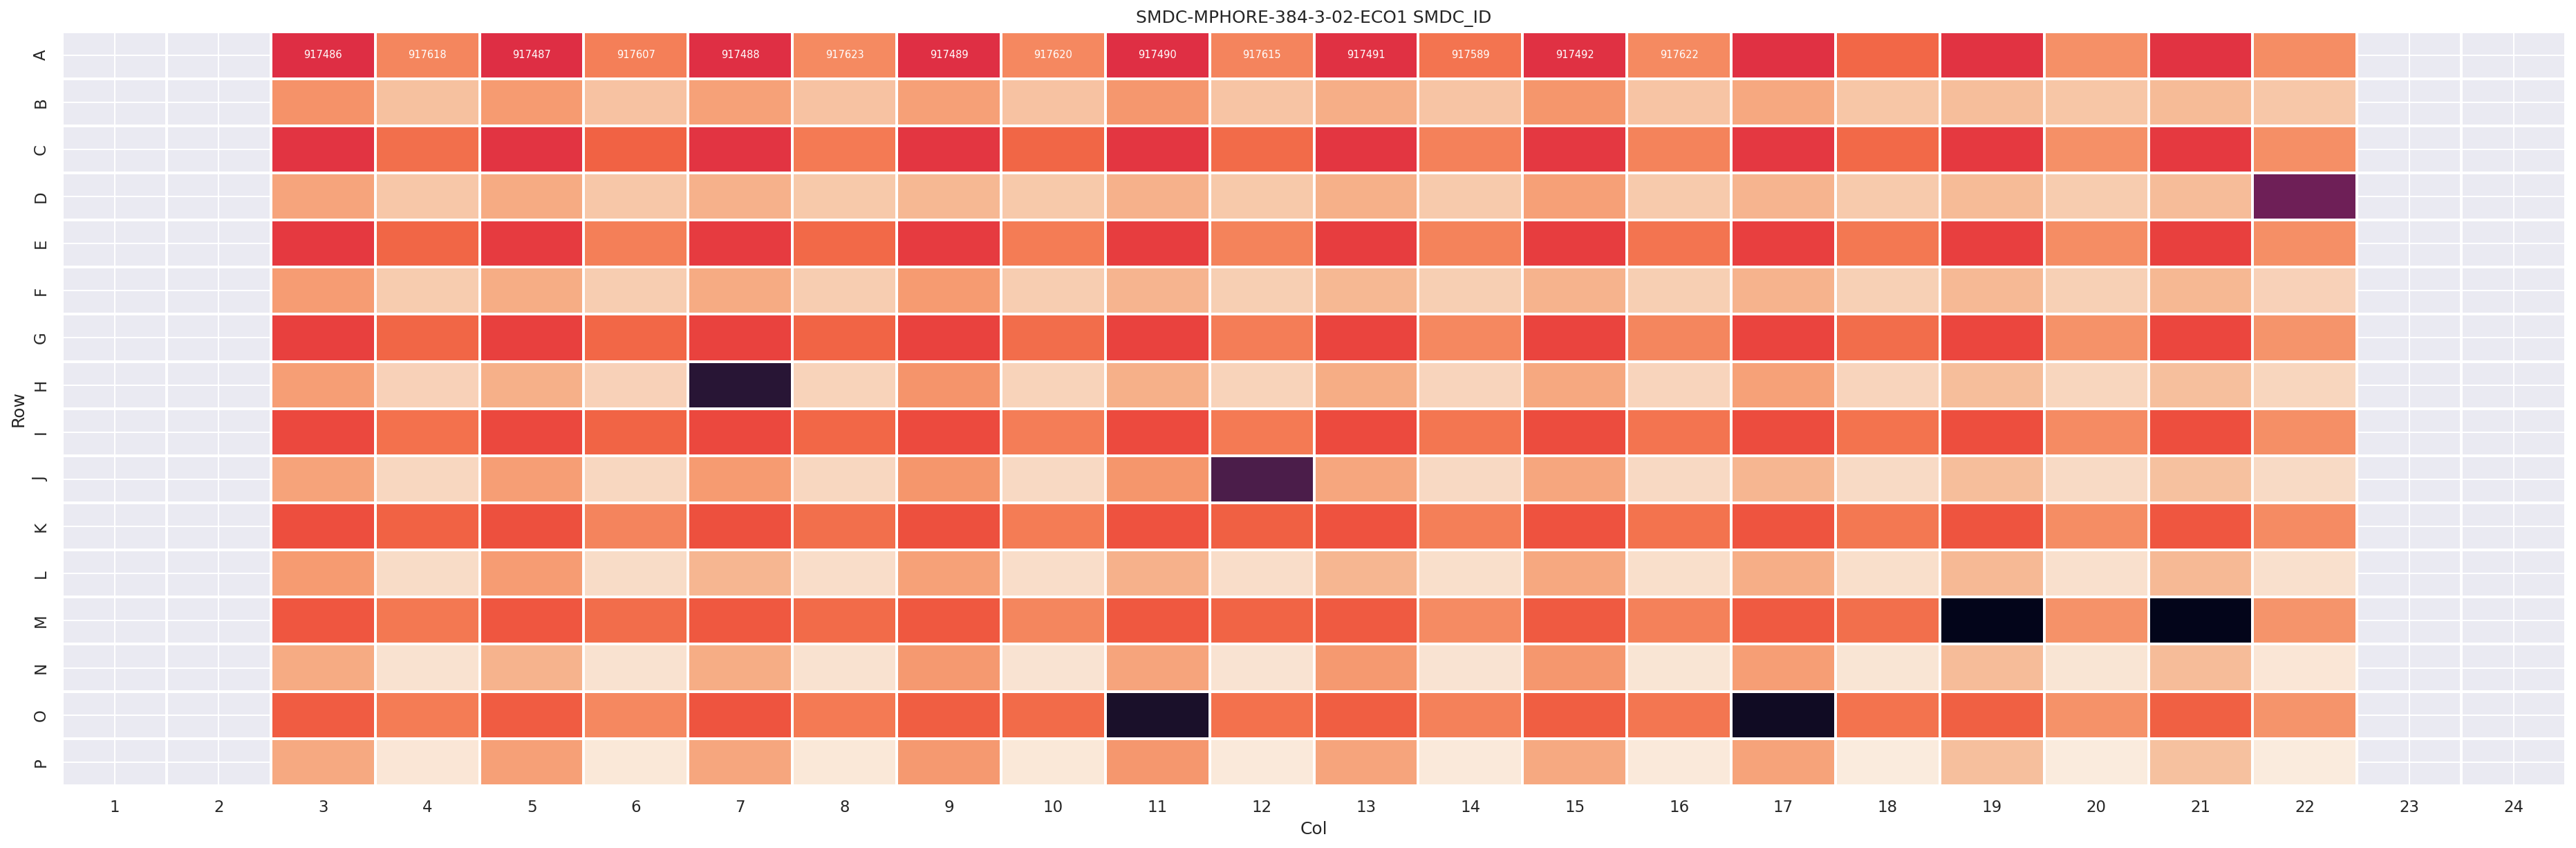

In [124]:
importlib.reload(pm)
pl=pm.make_platemaps_from_barcode(barcode=barcode, outdir=None)
pm.draw_plate_heatmap(barcode=barcode)

In [125]:
if pl.Conc_uM.unique()[0] is None:
    pl.Conc_uM=pl.Conc_nM/1000
pl.head()

,Well,Vendor_Alias,SMDC_ID,Common_Name,Lot_Num,Conc_uM,Conc_nM,SMILES,Row,Col,Plate
0,E18,None,917594.0,NaN,3.0,50000.0,None,CC(C(=O)NCCSSCCN(C)C)c1ccc(cc1)C(=O)c2cccs2,E,18,SMDC-MPHORE-384-3-02-ECO1
3,G23,None,NaN,NaN,None,None,None,None,G,23,SMDC-MPHORE-384-3-02-ECO1
4,I17,688,917533.0,NaN,1.0,50000.0,None,COc1ccc(cc1C(=O)NCCSSCCN(C)C)S(=O)(=O)C,I,17,SMDC-MPHORE-384-3-02-ECO1
7,A23,None,NaN,NaN,None,None,None,None,A,23,SMDC-MPHORE-384-3-02-ECO1
8,E11,665,917510.0,NaN,1.0,50000.0,None,COC(=O)[C@H](CSSCCN(C)C)NC(=O)c1cc(C)on1,E,11,SMDC-MPHORE-384-3-02-ECO1


In [126]:
pl=pl.rename(columns={'Plate':'Barcode'})
dfm=df.merge(pl, how='outer', on='Well')
dfm.head(2)

,Sample,Plate,Well,Fname,intensitymax,massatmax,linenum_start,linenum,intensityprint,intensityprotein,...,Vendor_Alias,SMDC_ID,Common_Name,Lot_Num,Conc_uM,Conc_nM,SMILES,Row,Col,Barcode
0,1,1,A03,202301027_WTFLNsp14_P3_A3,304911.0,60079.0,79,4081,..--illllllli--.......---iiiiiiii---.............,1464.67,...,641,917486.0,NaN,1.0,50000.0,None,COC(=O)[C@H](CSSCCN(C)C)NC(=O)c1cnc2ccccc2c1,A,3,SMDC-MPHORE-384-3-02-ECO1
1,2,1,A04,202301027_WTFLNsp14_P3_A4,594065.0,60146.0,4810,8812,..--illlllliiiiiii--........--illlllllllii--.....,1777.256,...,721,917618.0,NaN,1.0,50000.0,None,CCOc1ccc2ccccc2c1C(=O)NCCSSCCN(C)C,A,4,SMDC-MPHORE-384-3-02-ECO1


In [127]:
dfm.ICL_IC_ID.equals(dfm.SMDC_ID)

False

In [128]:
dfm.loc[dfm.ICL_IC_ID.isna(), 'percentlabeled']=0

In [129]:
dfm['percentlabeled']=dfm['percentlabeled'].astype(float)

In [130]:
dfm['hmlab']=dfm.percentlabeled.round(1)

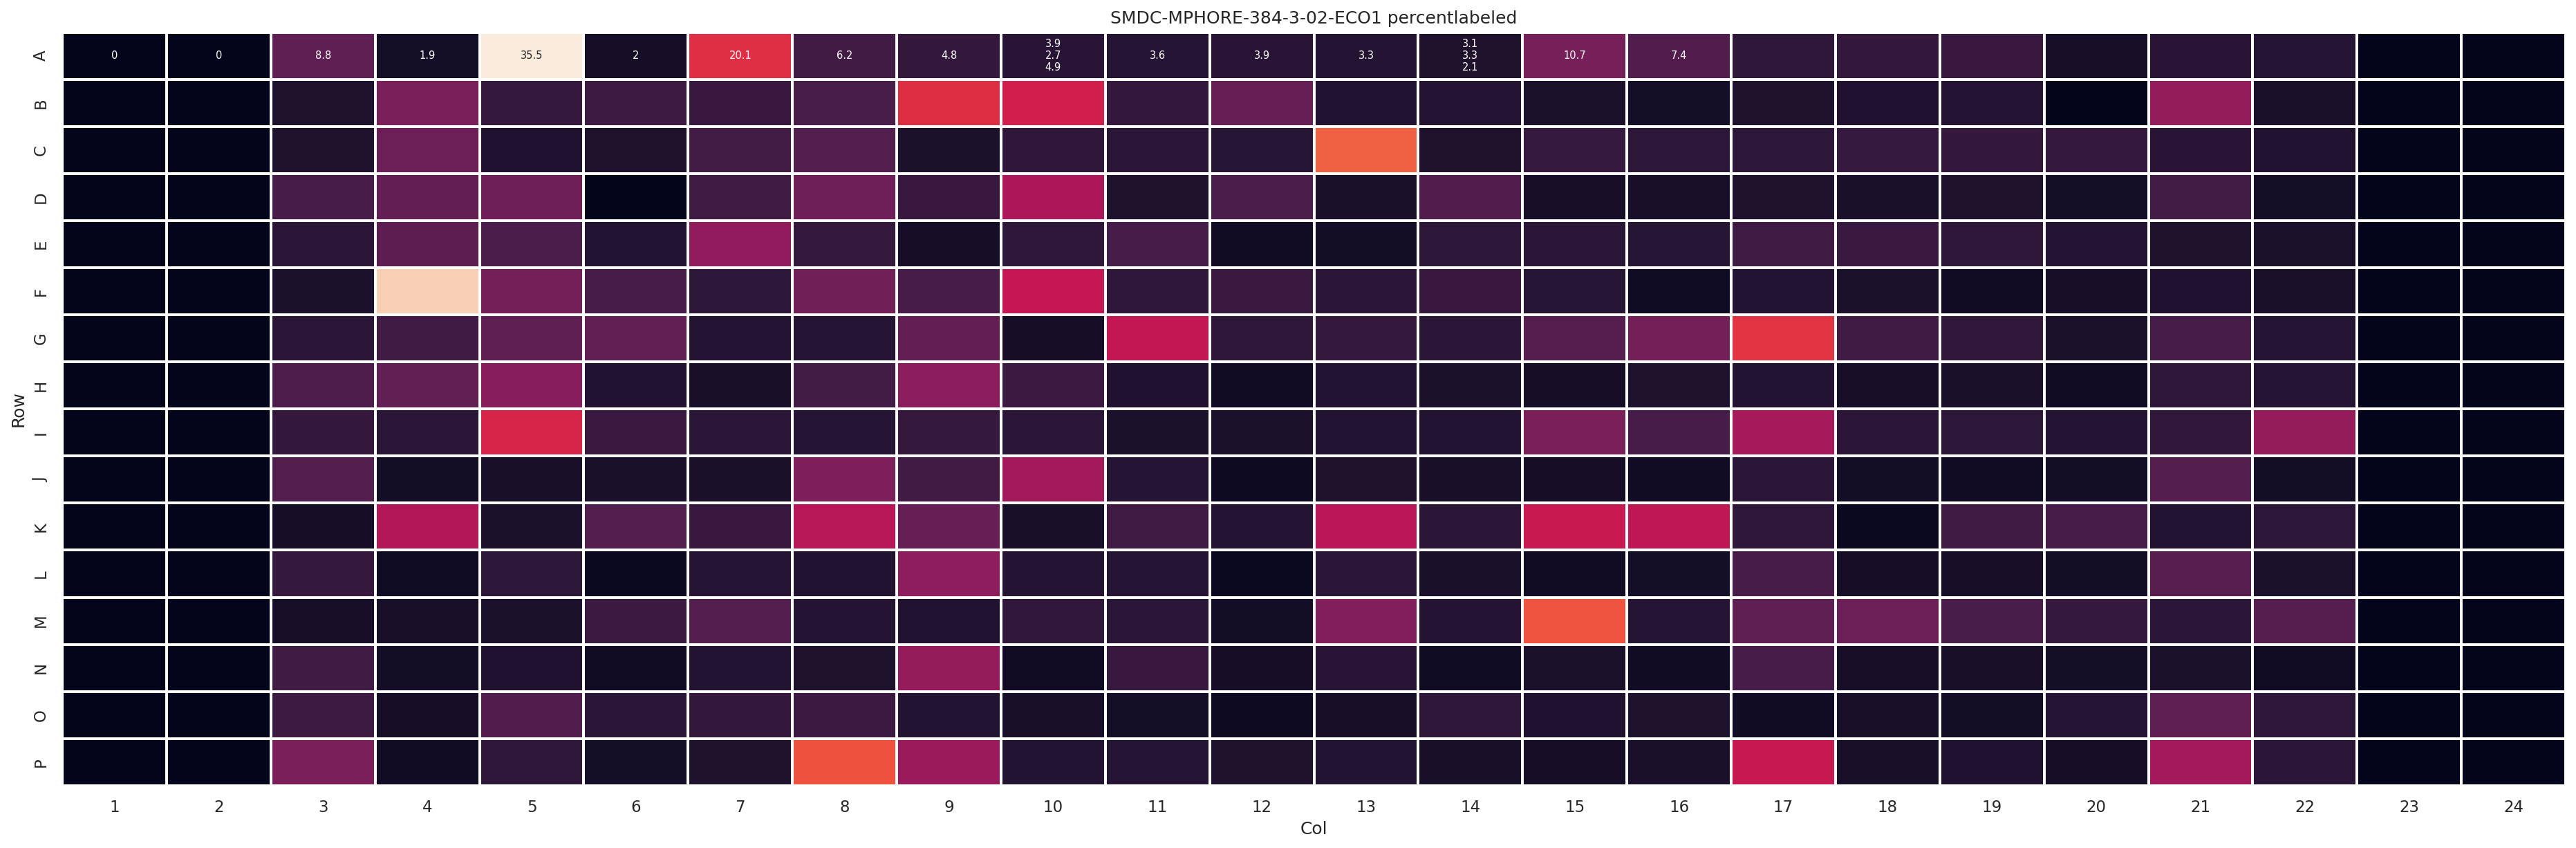

In [131]:
importlib.reload(pm)
pm.draw_plate_heatmap(barcode=barcode, df=dfm, wells='Well', values='percentlabeled', labels='hmlab', center=None, vmin=None, vmax=None, width=25, outdir=None)

In [153]:
# dfm[dfm.ICL_IC_ID==smdc]
smdc=dfm[dfm.Well=='E09'].ICL_IC_ID.iloc[0]
smdc

917509.0

In [154]:
dfm[dfm.SMDC_ID==smdc]

,Sample,Plate,Well,Fname,intensitymax,massatmax,linenum_start,linenum,intensityprint,intensityprotein,...,SMDC_ID,Common_Name,Lot_Num,Conc_uM,Conc_nM,SMILES,Row,Col,Barcode,hmlab
116,87,1,E09,202301027_WTFLNsp14_P3_E9,318593.0,60145.0,398882,402884,.........---iillllllllllli-.......---iilllllll...,1989.161,...,917509.0,NaN,1.0,50000.0,None,COC(=O)[C@H](CSSCCN(C)C)NC(=O)C1(CCCC1)c2ccc(F...,E,9,SMDC-MPHORE-384-3-02-ECO1,2.0


/home/apaulson/atomsci/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/apaulson/atomsci/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/apaulson/atomsci/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/apaulson/atomsci/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

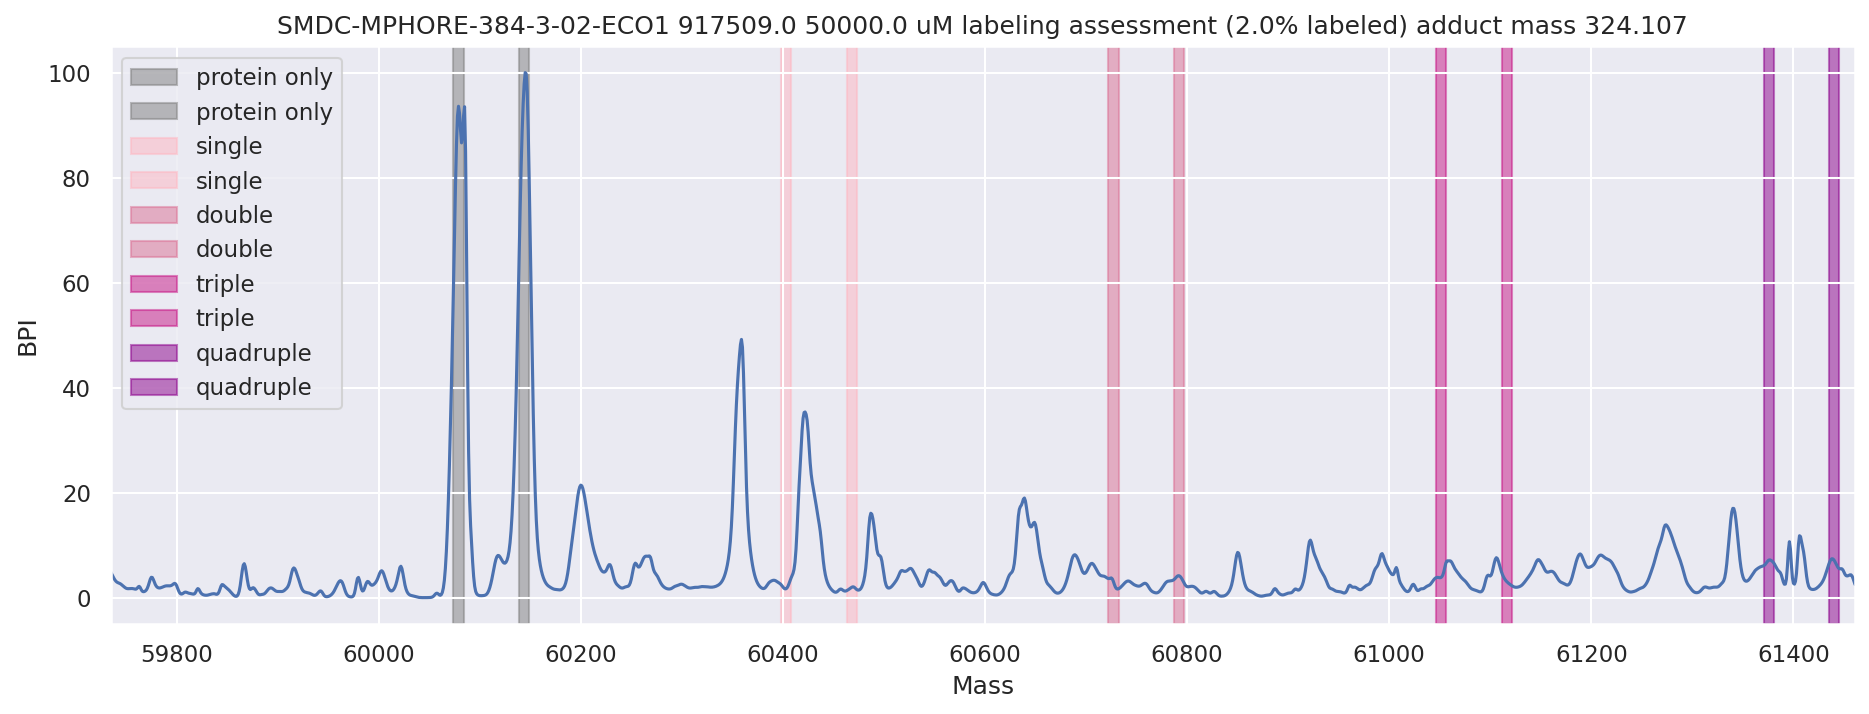

In [155]:
dfm.SMDC_ID=dfm.SMDC_ID.astype(float)
for i, row in dfm[dfm.SMDC_ID==smdc].iterrows():
    sample=row.Sample
    conc=row.Conc_uM
    conc_unit='uM'
    if conc is None:
        conc=row.Conc_nM
        conc_unit='nM'
    pct=row.hmlab

    dat=pd.read_csv(f'Sample_{str(sample).zfill(3)}_data.txt', sep='\t')
    dat.columns=['Mass','BPI']
    dat=dat.astype(float)
    dat.head(2)

    adduct_mass=float(row.adduct_mass)
    
    xmin=protein_mass-dfm[dfm.SMDC_ID==smdc].adduct_mass.astype(float).min()-4*scan_range
    xmax=protein_mass2+4*dfm[dfm.SMDC_ID==smdc].adduct_mass.astype(float).max()+4*scan_range

    colors=['gray','lightpink','palevioletred','mediumvioletred','darkmagenta']
    labels=['protein only','single','double','triple','quadruple']
    fig, ax = plt.subplots(1, figsize=(15,5))
    sns.lineplot(data=dat, x='Mass', y='BPI')
    for mult in [0,1,2,3,4]:
        ax.axvspan(protein_mass+mult*adduct_mass-scan_range, protein_mass+mult*adduct_mass+scan_range, color=colors[mult], label=labels[mult], zorder=0, alpha=0.5)
        ax.axvspan(protein_mass2+mult*adduct_mass-scan_range, protein_mass2+mult*adduct_mass+scan_range, color=colors[mult], label=labels[mult], zorder=0, alpha=0.5)
    ax.set_xlim(xmin, xmax)
    ax.legend()
    ax.set_title(f'{barcode} {smdc} {conc} {conc_unit} labeling assessment ({pct}% labeled) adduct mass {adduct_mass}');

#     protnums=df.loc[df['Sample']==sample,[x for x in df.columns if 'min' in x]].T
#     protnums=protnums.sort_values(by=protnums.columns[0])
#     protnums=protnums[~protnums[protnums.columns[0]].isna()]
#     cols=protnums.index.tolist()
#     cols=[x.replace('_min','') for x in cols]
#     cols

#     pal=sns.color_palette("viridis", len(cols))
#     fig, ax = plt.subplots(1, figsize=(15,5))
#     sns.lineplot(data=dat, x='Mass', y='BPI')
#     ax.axvspan(protein_mass-scan_range, protein_mass+scan_range, color='gray', label='protein_only', zorder=0, alpha=0.5)
#     for i, lab in enumerate(cols):
#         ax.axvspan(df[df.Sample==sample][f'{lab}_min'].astype(float).iloc[0],
#                    df[df.Sample==sample][f'{lab}_max'].astype(float).iloc[0], 
#                    label=lab, color=pal[i], zorder=0, alpha=0.5)

#     ax.set_xlim(xmin, xmax)
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     ax.set_title(f'{barcode} {smdc} {conc} {conc_unit} labeling assessment');

In [139]:
dfm.shape

(532, 54)

In [140]:
# dfm.to_csv(f'/Volumes/Shared/SMDC/Screens/2023-11_Project_XXX_Nsp14_Fujimori_Avidd4/{barcode}_double_protein_mass.csv')

In [141]:
dfm[(dfm.percentlabeled==0)&(~dfm.Sample.isna())]

,Sample,Plate,Well,Fname,intensitymax,massatmax,linenum_start,linenum,intensityprint,intensityprotein,...,SMDC_ID,Common_Name,Lot_Num,Conc_uM,Conc_nM,SMILES,Row,Col,Barcode,hmlab


In [142]:
barcode

'SMDC-MPHORE-384-3-02-ECO1'

/home/apaulson/atomsci/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/apaulson/atomsci/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/apaulson/atomsci/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/apaulson/atomsci/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

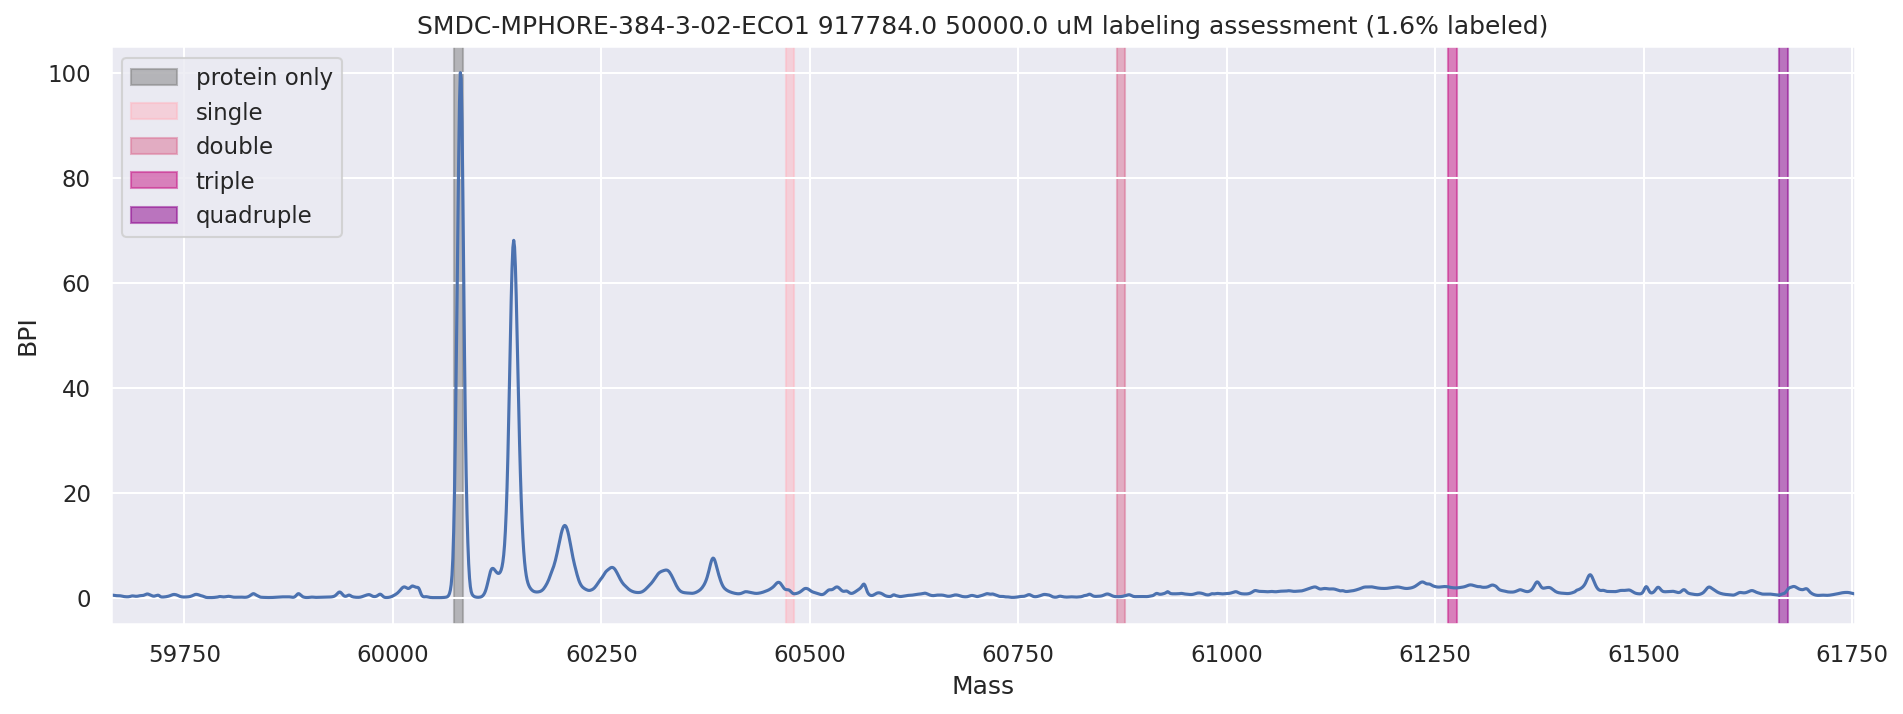

In [143]:
for well in dfm[dfm.ICL_IC_ID==smdc].Well:
    sample=dfm[dfm.Well==well].Sample.iloc[0]
    conc=dfm[dfm.Well==well].Conc_uM.iloc[0]
    conc_unit='uM'
    if conc is None:
        conc=dfm[dfm.Well==well].Conc_nM.iloc[0]
        conc_unit='nM'
    pct=dfm[dfm.Well==well].hmlab.iloc[0]

    dat=pd.read_csv(f'Sample_{str(sample).zfill(3)}_data.txt', sep='\t')
    dat.columns=['Mass','BPI']
    dat=dat.astype(float)
    dat.head(2)

    adduct_mass=df[df.Sample==sample].adduct_mass.astype(float).iloc[0]
    # xmin=protein_mass-adduct_mass-4*scan_range
    # xmax=protein_mass+4*adduct_mass+4*scan_range

    colors=['gray','lightpink','palevioletred','mediumvioletred','darkmagenta']
    labels=['protein only','single','double','triple','quadruple']
    fig, ax = plt.subplots(1, figsize=(15,5))
    sns.lineplot(data=dat, x='Mass', y='BPI')
    for mult in [0,1,2,3,4]:
        ax.axvspan(protein_mass+mult*adduct_mass-scan_range, protein_mass+mult*adduct_mass+scan_range, color=colors[mult], label=labels[mult], zorder=0, alpha=0.5)
    ax.set_xlim(xmin, xmax)
    ax.legend()
    ax.set_title(f'{barcode} {smdc} {conc} {conc_unit} labeling assessment ({pct}% labeled)');

#     protnums=df.loc[df['Sample']==sample,[x for x in df.columns if 'min' in x]].T
#     protnums=protnums.sort_values(by=protnums.columns[0])
#     protnums=protnums[~protnums[protnums.columns[0]].isna()]
#     cols=protnums.index.tolist()
#     cols=[x.replace('_min','') for x in cols]
#     cols

#     pal=sns.color_palette("viridis", len(cols))
#     fig, ax = plt.subplots(1, figsize=(15,5))
#     sns.lineplot(data=dat, x='Mass', y='BPI')
#     ax.axvspan(protein_mass-scan_range, protein_mass+scan_range, color='gray', label='protein_only', zorder=0, alpha=0.5)
#     for i, lab in enumerate(cols):
#         ax.axvspan(df[df.Sample==sample][f'{lab}_min'].astype(float).iloc[0],
#                    df[df.Sample==sample][f'{lab}_max'].astype(float).iloc[0], 
#                    label=lab, color=pal[i], zorder=0, alpha=0.5)

#     ax.set_xlim(xmin, xmax)
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     ax.set_title(f'{barcode} {smdc} {conc} {conc_unit} labeling assessment');

# Rough DR curve analysis

In [ ]:
import numpy as np
import plot_curves as pc

In [496]:
dfm=dfm.sort_values(['Conc_uM','ICL_IC_ID',])

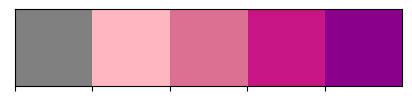

In [497]:
sns.palplot(colors)

In [498]:
smdc=1124895
tmp=dfm[dfm.ICL_IC_ID==smdc].copy()

In [500]:
tmp.percentsecondary

172    5.927114
19     5.653877
173    6.345585
20     5.883449
174    6.418588
21            0
175     6.40388
22            0
176           0
23            0
177           0
24            0
25            0
178           0
179           0
26            0
Name: percentsecondary, dtype: object

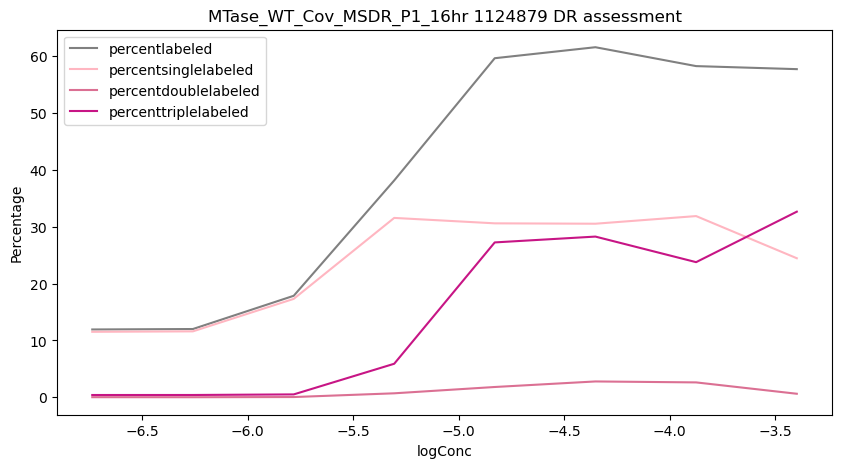

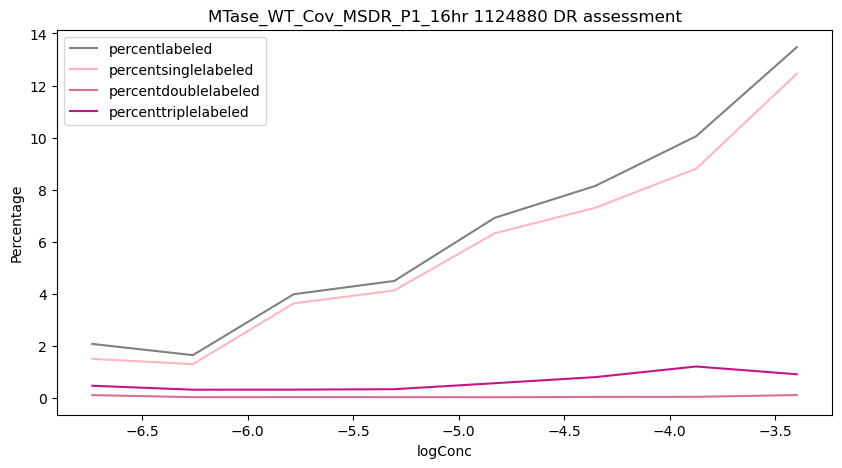

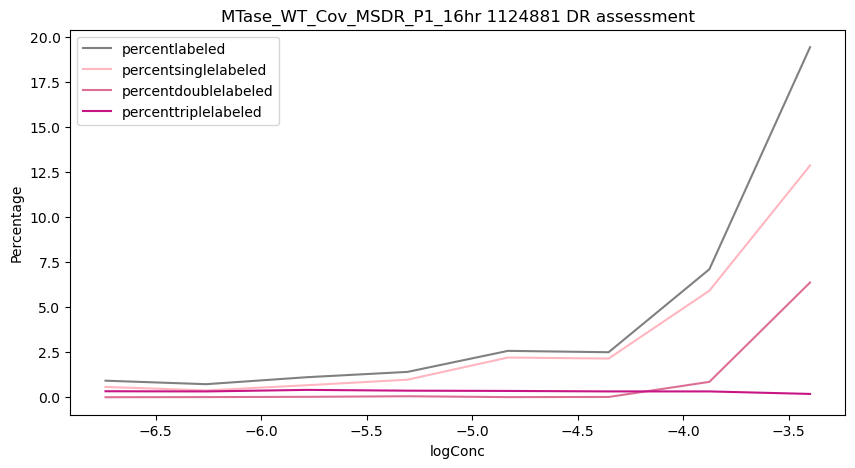

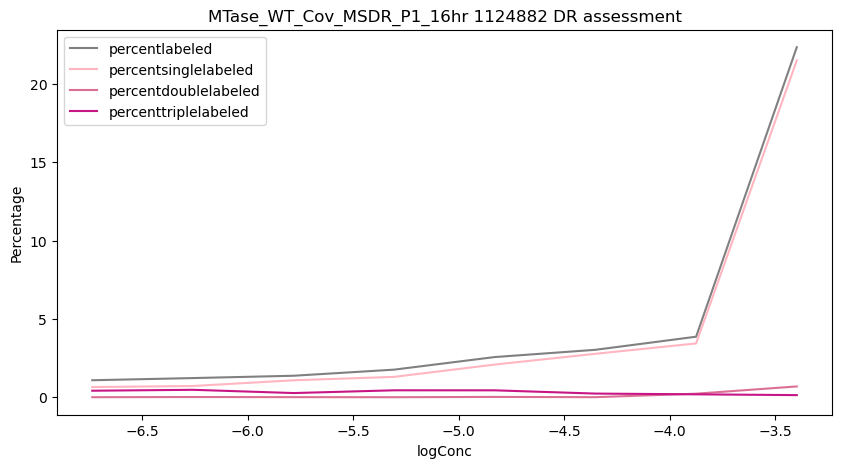

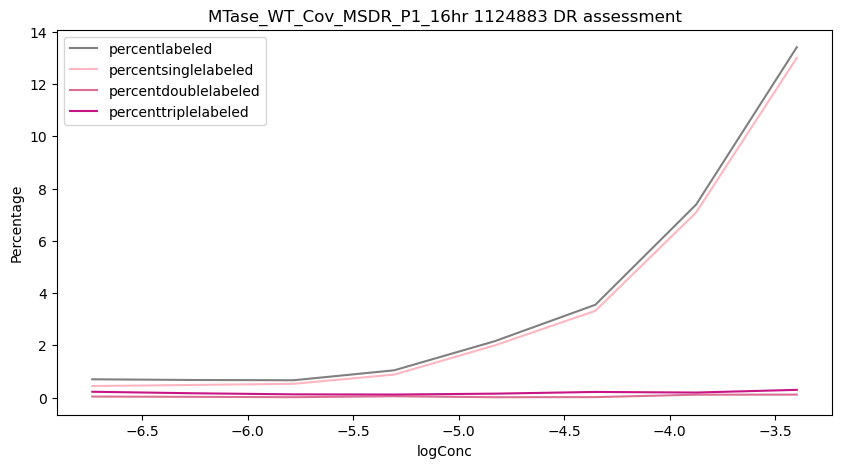

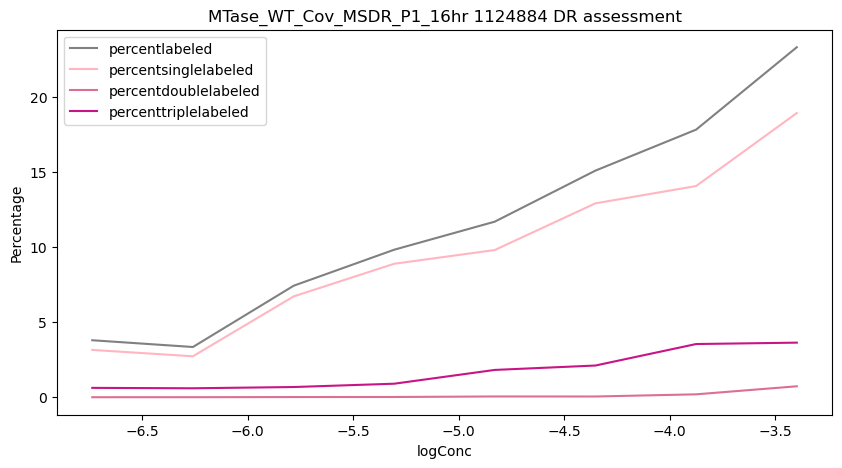

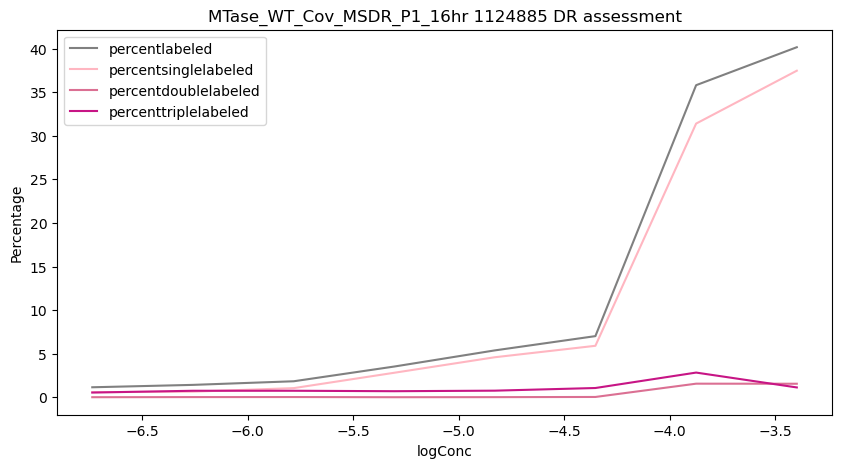

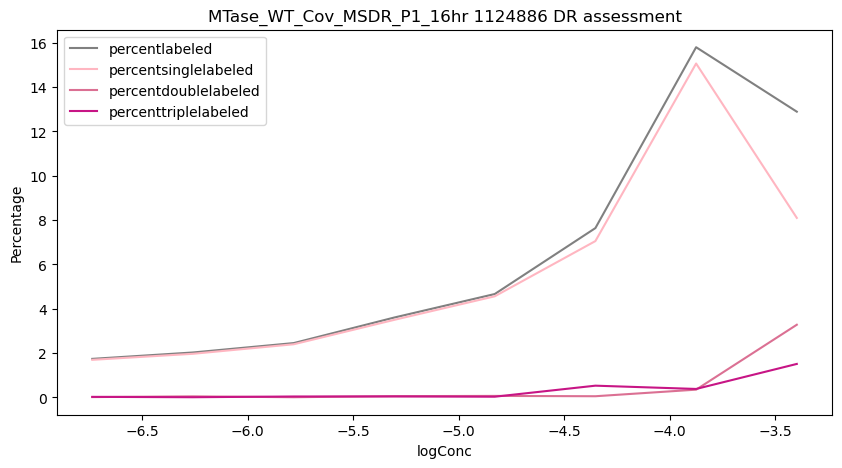

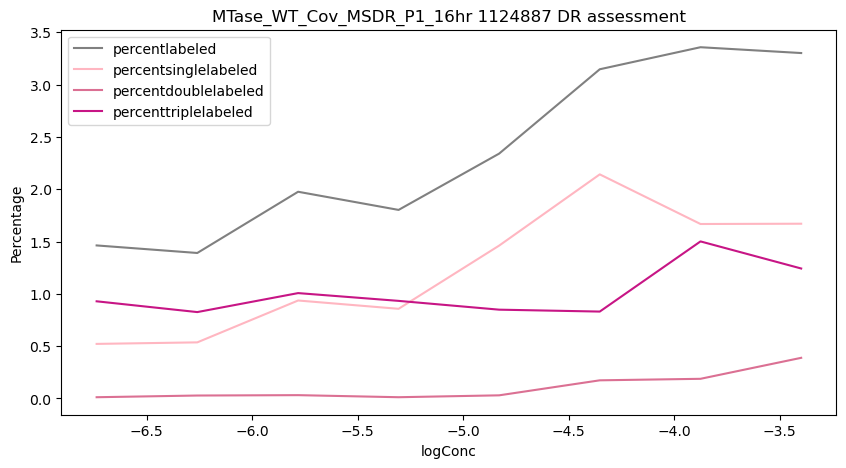

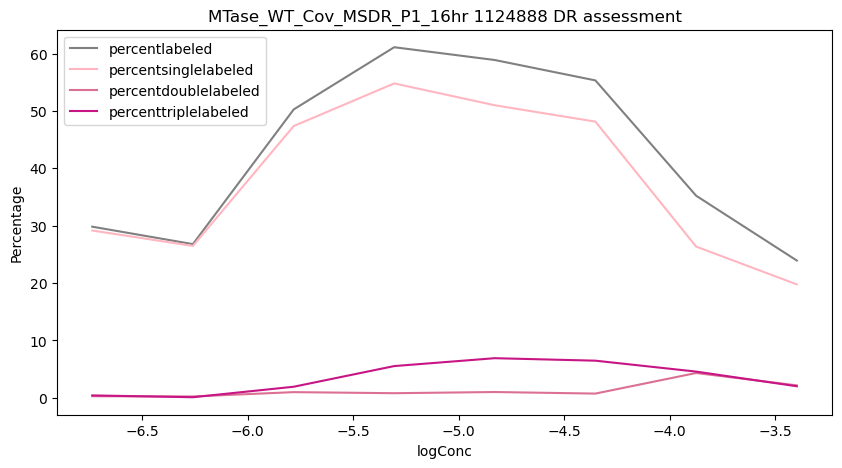

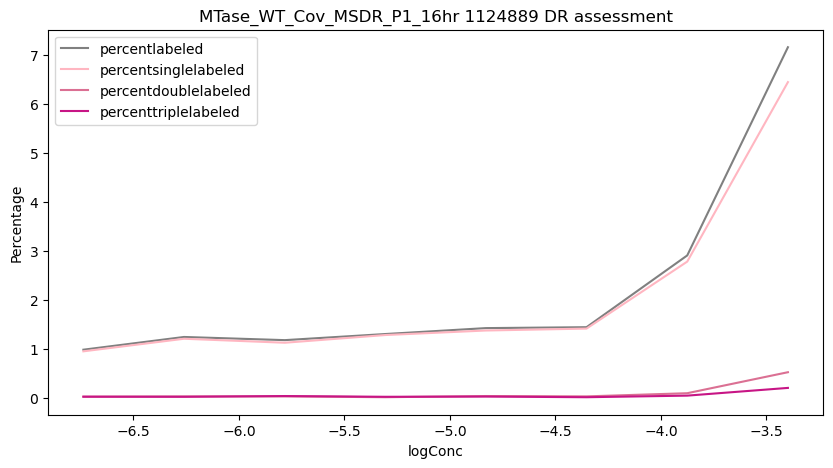

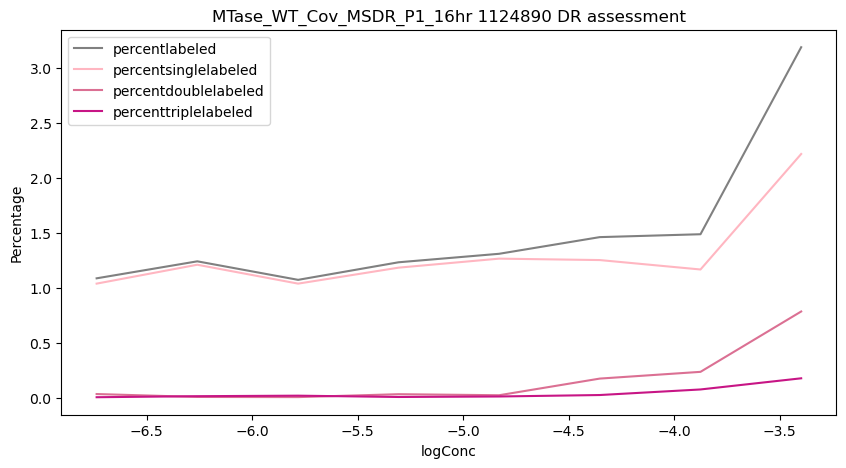

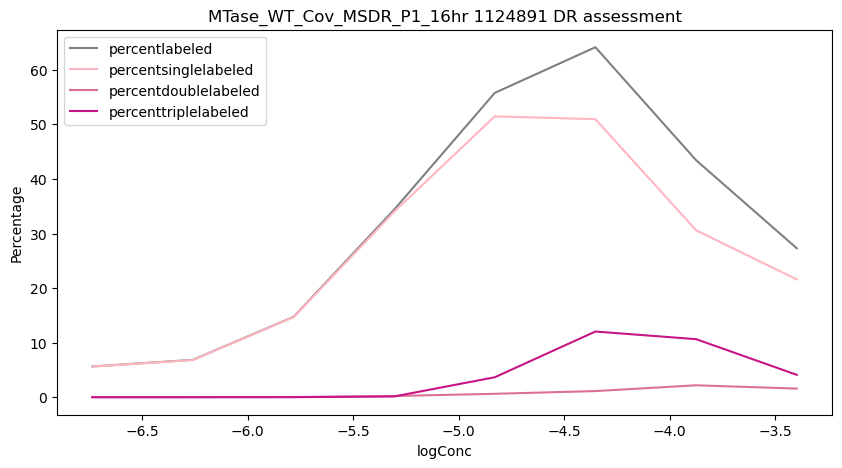

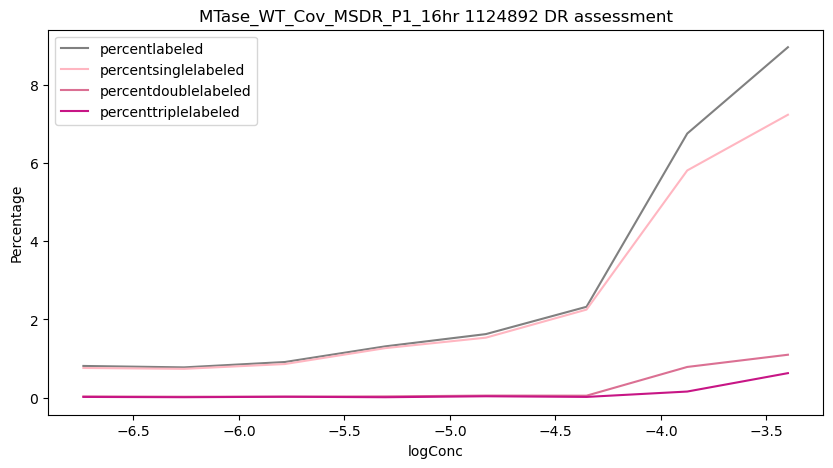

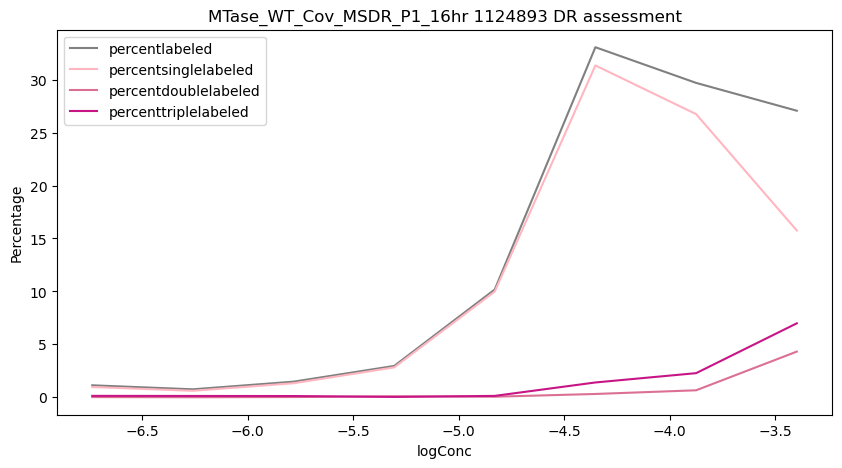

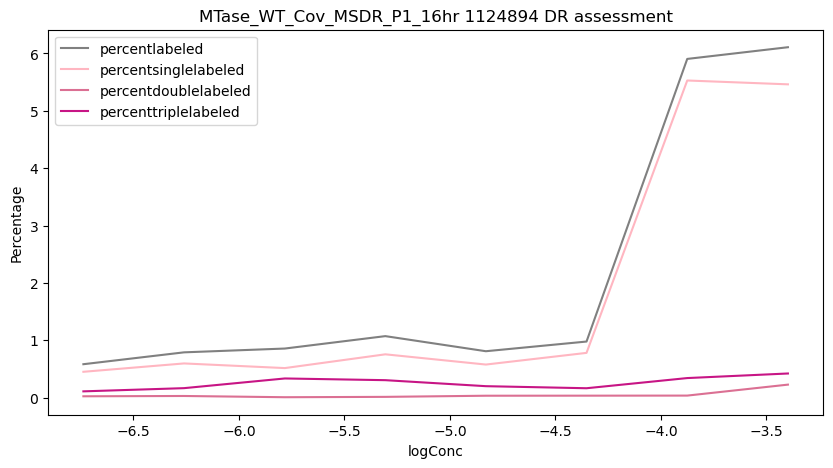

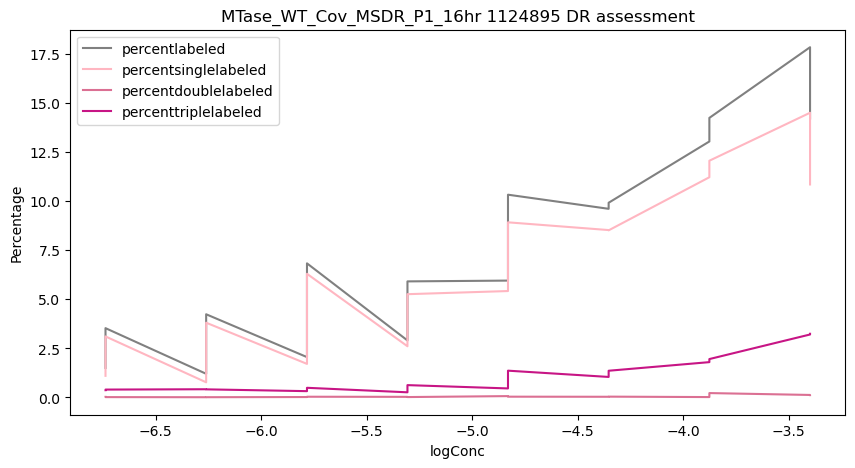

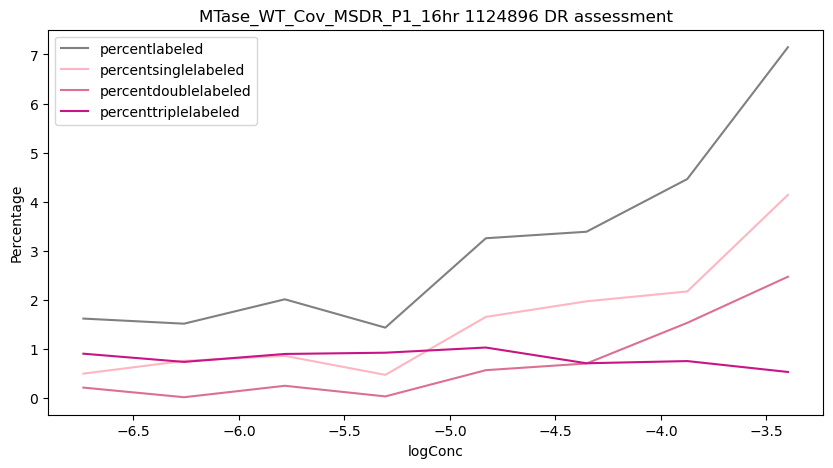

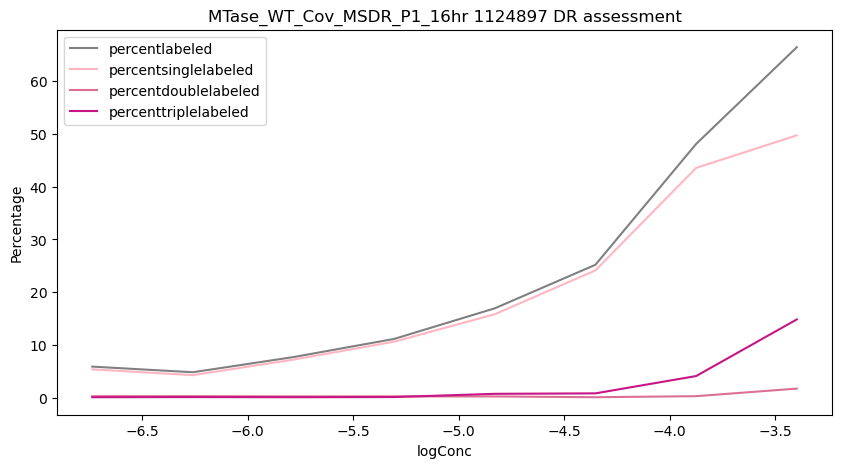

In [485]:
for smdc in dfm.ICL_IC_ID.unique():
    if np.isnan(smdc):
        continue
    tmp=dfm[dfm.ICL_IC_ID==smdc].copy()
    tmp['logConc']=[np.log10(x/1000000) for x in tmp.Conc_uM]

    tmp=tmp[tmp.Conc_uM<500]

    importlib.reload(pc)
    fig, ax = plt.subplots(1, figsize=(10,5))
    for i, lab in enumerate(['percentlabeled','percentsinglelabeled', 'percentdoublelabeled', 'percenttriplelabeled',]):
        # pc.ModelAndScatterPlot(tmp.logConc, tmp[lab], label=lab, ax=ax, color=colors[i], init=[100, -5, -5., 1],
        #                       bounds=([0,-20,-np.inf,-np.inf], [120, 20, np.inf,np.inf]))
        ax.plot(tmp.logConc, tmp[lab], label=lab, color=colors[i])
    ax.legend()#loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('logConc')
    ax.set_ylabel('Percentage')
    ax.set_title(f'{barcode} {int(smdc)} DR assessment');

# Draw molecules

## Draw molecules on their own


917263	355	    404	2	C18

917455	311.55	295	2	J22

917461	352.564	281	2	L14

917465	306.367	293	2	L22

917476	273.458	256	2	P4

917634	277.47	327	3	A20

917509	323.584	280	3	E9

In [1]:
from atomsci.ddm.utils import struct_utils as su
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import numpy as np
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem import rdMolHash

In [2]:
compounds=[917263,917455,917461,917465,917476,917634,917509]
drawsmiles=dfm[dfm.SMDC_ID.astype(float).isin(compounds)].SMILES.tolist()
drawsmiles

NameError: name 'dfm' is not defined

In [146]:
# get list of mol objects from smiles
mols = [su.base_mol_from_smiles(x) for x in drawsmiles]
mols

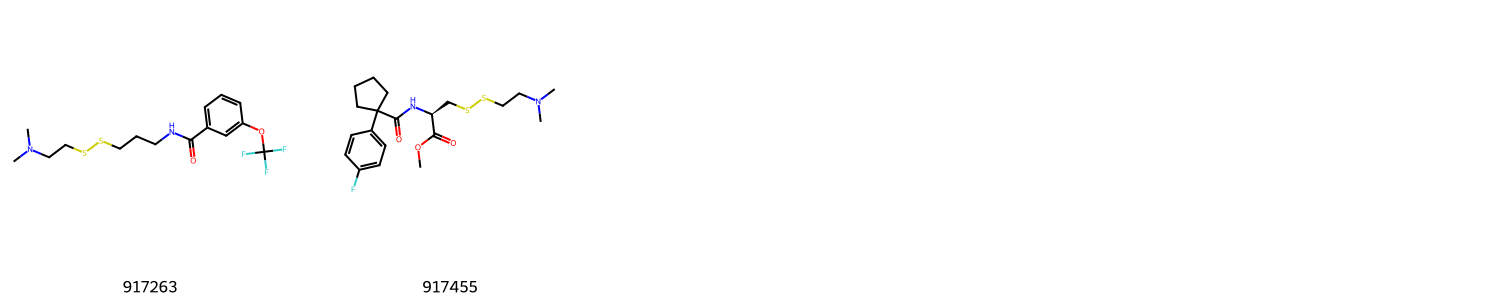

In [147]:
ids = compounds

# align mol's to make images prettier
align_by='sulfide' # choose 'mcs' or 'sulfide' to align based on substructure or the sulfide handle

if align_by=='mcs':
  template=mols[0]
elif align_by=='sulfide':
  template=Chem.MolFromSmiles('SCCN')
  mols=np.append(mols,template)
AllChem.Compute2DCoords(template)
mcs = FindMCS(mols, 
              completeRingsOnly=True, 
              ringMatchesRingOnly=True, 
              timeout=10)
patt = Chem.MolFromSmarts(mcs.smartsString)
template_match = template.GetSubstructMatch(patt)
if align_by=='sulfide':
  mols=np.delete(mols, -1)
for mol in mols:
  query_match = mol.GetSubstructMatch(patt)
  AllChem.Compute2DCoords(mol)
  rms = AllChem.AlignMol(mol, template, atomMap=list(zip(query_match,template_match)))

# draw molecules
Draw.MolsToGridImage(mols, legends=[str(id) for id in ids], molsPerRow=5, subImgSize=(300,300), useSVG=True)

## with Maximum Common Substructure highlighted

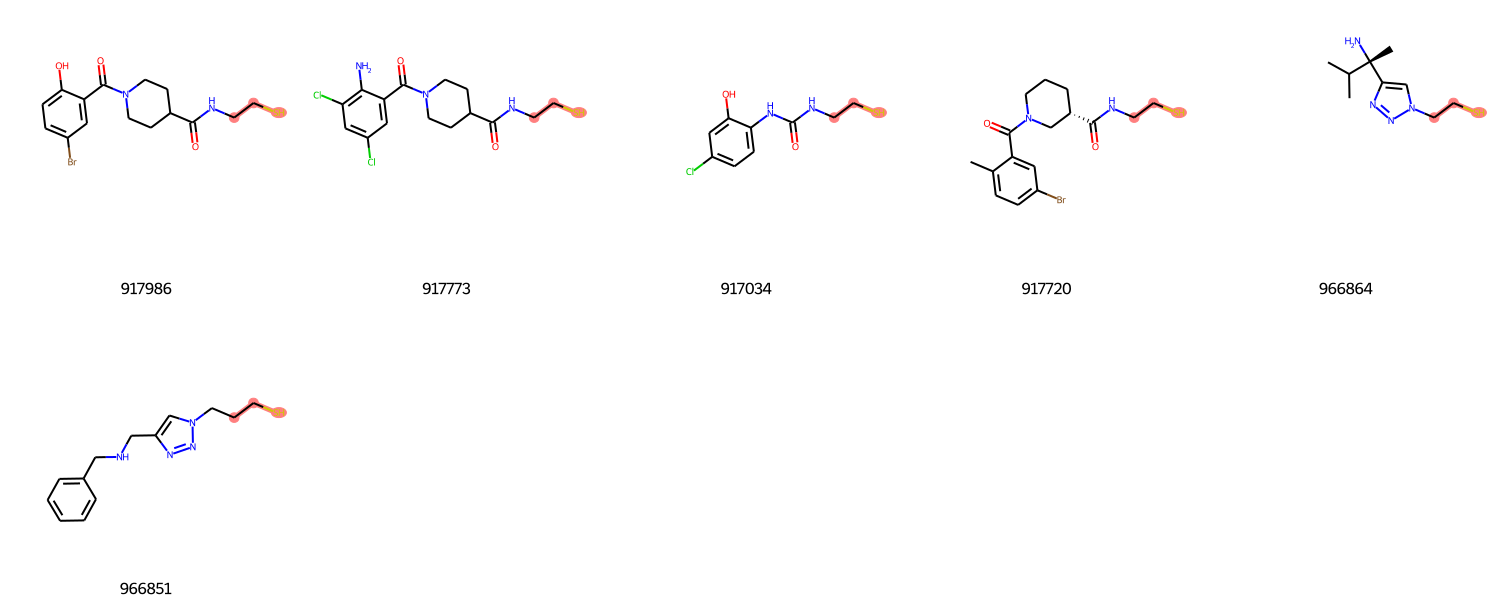

In [63]:
# find MCS (informative?? maybe)
mcs = FindMCS(mols, completeRingsOnly=True, ringMatchesRingOnly=True, timeout=10)
mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
# draw mol's with MCS highlighted
highlight_mcs = [mol.GetSubstructMatch(mcs_mol) for mol in mols]
Draw.MolsToGridImage(mols, legends=[id for id in ids], molsPerRow=5,
                     highlightAtomLists = highlight_mcs, subImgSize=(300,300), useSVG=True)

## With Murcko scaffold highlighted
https://www.rdkit.org/docs/Cookbook.html#molecule-hash-strings




['c1ccc(Nc2ccccc2)cc1', 'c1ccc2cc(CCN3CCCCC3)ccc2c1', 'c1ccc(Nc2ccccc2CN2CCCCC2)cc1', 'c1ccc(Oc2ccccc2CN2CCCCC2)cc1', 'c1ccccc1', 'c1ccc(Nc2ccccc2CN2CCCCC2)cc1', 'c1ccc(CCC(CN2CCCCC2)c2cc3ccccc3[nH]2)cc1', 'c1ccc(-c2ccco2)cc1', 'c1ccc(Oc2cccc(CN3CCCCC3)c2)cc1', 'c1ccc2cc(OCCN3CCCCC3)ccc2c1', 'c1ccc(CN2CCCCC2)cc1', 'c1ccc(CCN2CCCCC2)cc1', 'c1ccc([SH4]NCCN2CCCCC2)cc1', 'c1ccc(C2CCNCC2)cc1', 'c1ccc(Oc2ccc(CN3CCCCC3)cc2)cc1', 'c1ccc(Nc2ccccc2CN2CCCCC2)cc1', 'c1ccc(CNc2ccccc2)cc1']
c1ccc(Nc2ccccc2CN2CCCCC2)cc1


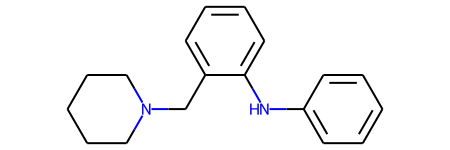

In [ ]:
# Calculate Murcko Scaffold Hashes
murckoHashList = [rdMolHash.MolHash(mol, Chem.rdMolHash.HashFunction.MurckoScaffold) for mol in mols]
print(murckoHashList)
# Get the most frequent Murcko Scaffold Hash
def mostFreq(list):
    return max(set(list), key=list.count)
mostFreq_murckoHash = mostFreq(murckoHashList)
print(mostFreq_murckoHash)
# draw most frequent Murcko scaffold
mostFreq_murckoHash_mol = Chem.MolFromSmiles(mostFreq_murckoHash)
mostFreq_murckoHash_mol

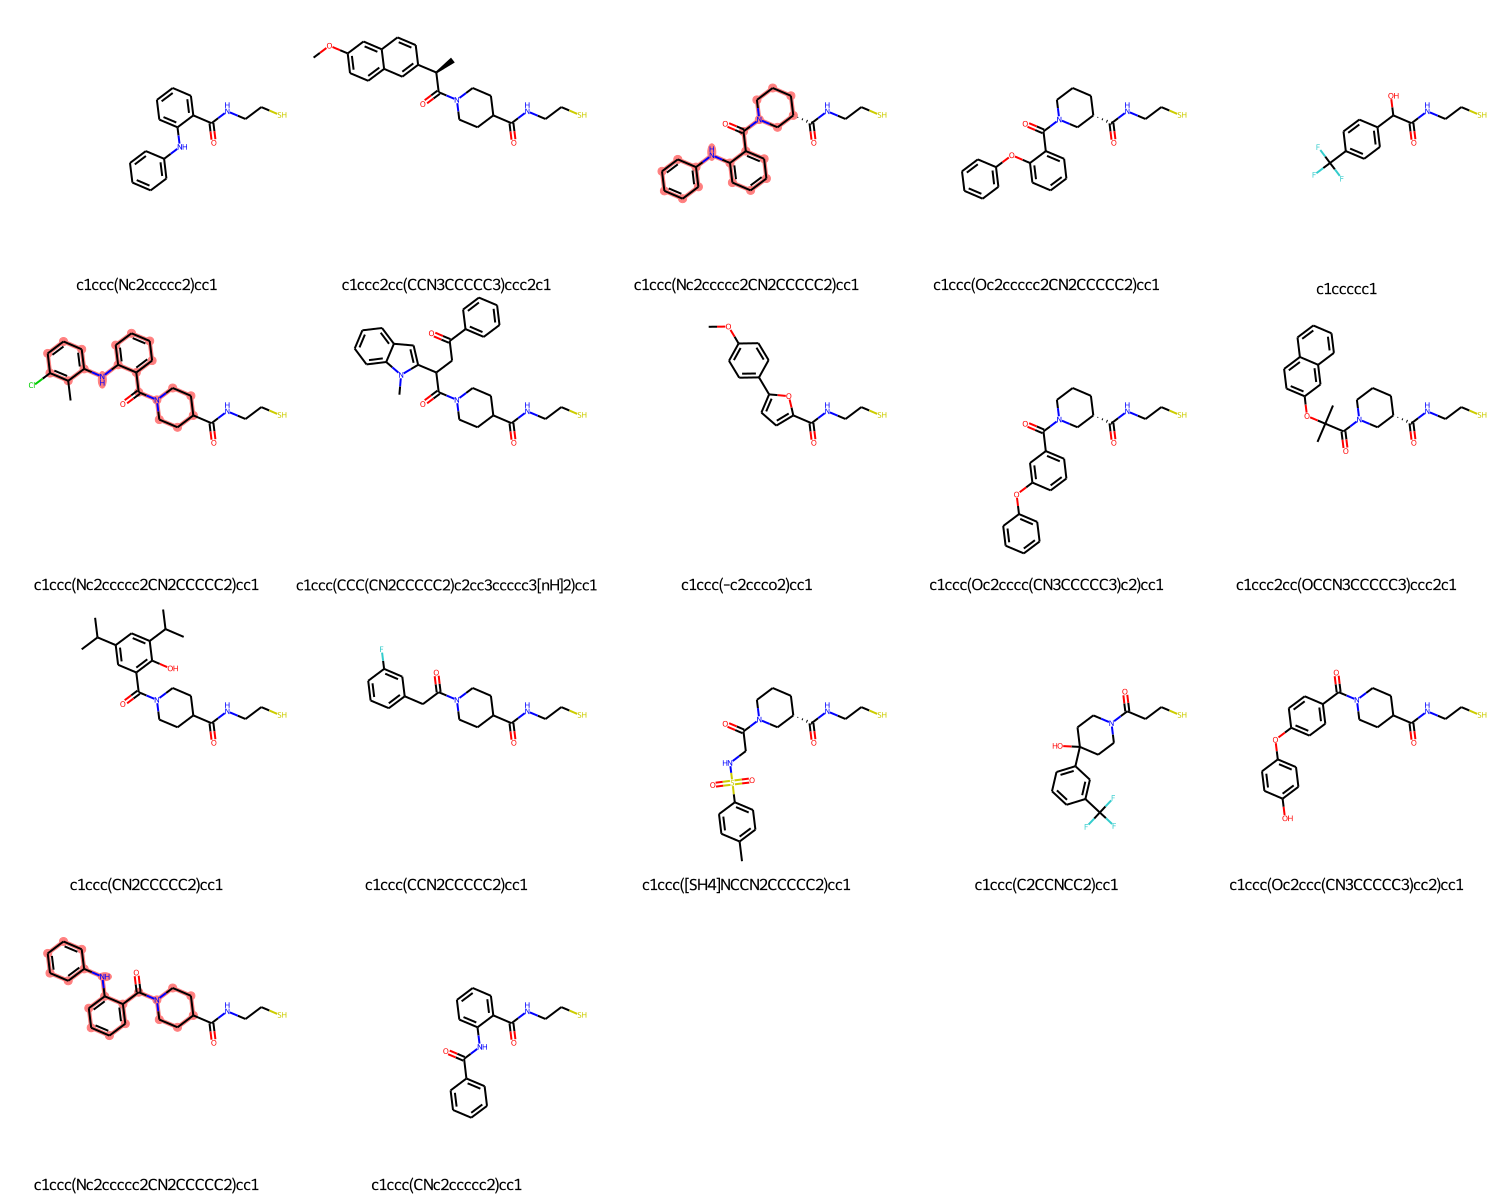

In [ ]:
# Display molecules with Murko scaffold as legends and highlight the mostFreq_murckoHash
highlight_mostFreq_murckoHash = [mol.GetSubstructMatch(mostFreq_murckoHash_mol) for mol in mols]
Draw.MolsToGridImage(mols,legends=[murckoHash for murckoHash in murckoHashList],
                     highlightAtomLists = highlight_mostFreq_murckoHash,
                     subImgSize=(300,300), useSVG=True, molsPerRow=5)

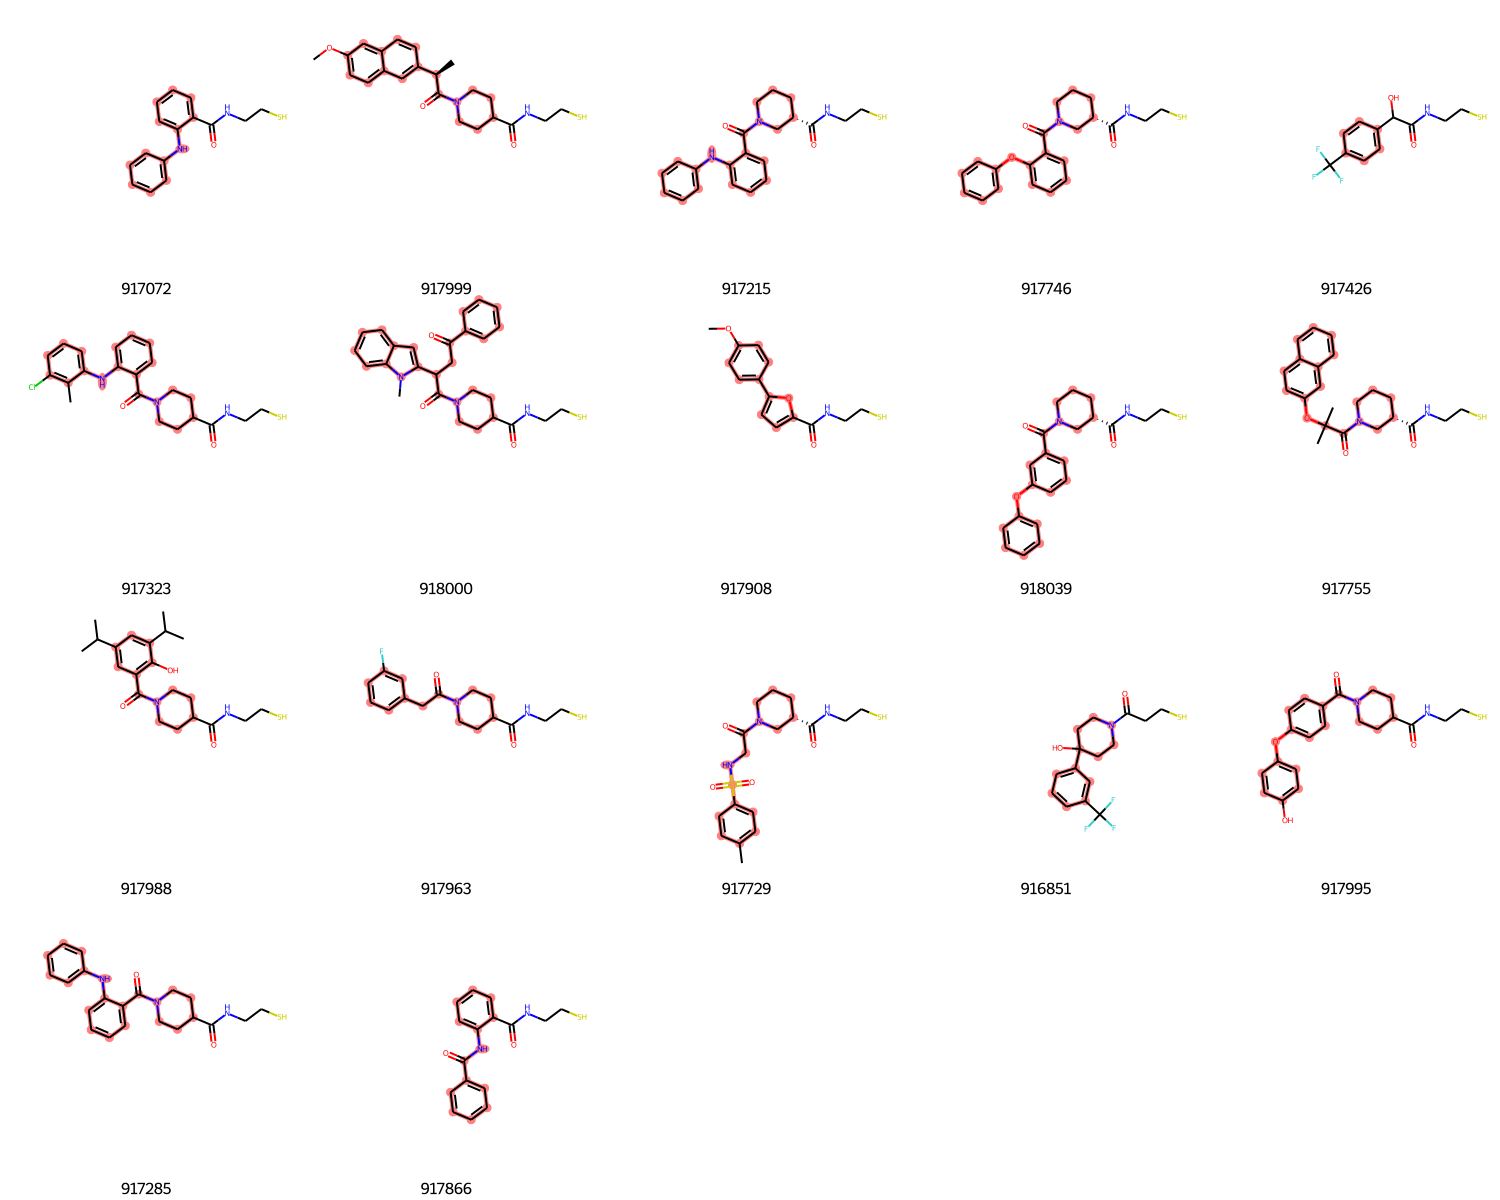

In [ ]:
# Display molecules with ID as legends and highlight the full Murcko scaffold for each compound
highlight_murckoHash = []
for murcko, mol in zip(murckoHashList, mols):
  murckoHash_mol=Chem.MolFromSmiles(murcko)
  highlight_murckoHash.append(mol.GetSubstructMatch(murckoHash_mol))

Draw.MolsToGridImage(mols, legends=[id for id in ids],
                     highlightAtomLists = highlight_murckoHash,
                     subImgSize=(300,300), useSVG=True, molsPerRow=5)